# Tensor Train

## Introduction and motivations for tensor train

### what is a tensor ?
- A point is a 0-dimensional tensor (aka tensor of order 0)
- A vector is a 1-dimensional tensor (aka tensor of order 1)
- A matrix is a 2-dimensional tensor (aka tensor of order 2)
- A 3-dimensional tensor is a tensor of order 3. Example: a color RGB image is a 3-dimensional tensor
- A 4-dimensional tensor is a tensor of order 4. Example: a batch of color RGB images is a 4-dimensional tensor, or a video.
- etc.
### Tensor Train overview
A tensor $A∈\mathbb{R}^{n_1 \times \cdots n_d}$ is represented in the **TT format** as:
$$A(i_1,\cdots,i_d) = G_1(i_1)\cdots G_d(i_d) $$
Each $G_k(i_k)\in \mathbb{R}^{r_{k-1}}\times r_k$ is called a **TT-core** , where $r_0=1,r_d=1$, and $r_k$ are the TT-ranks .

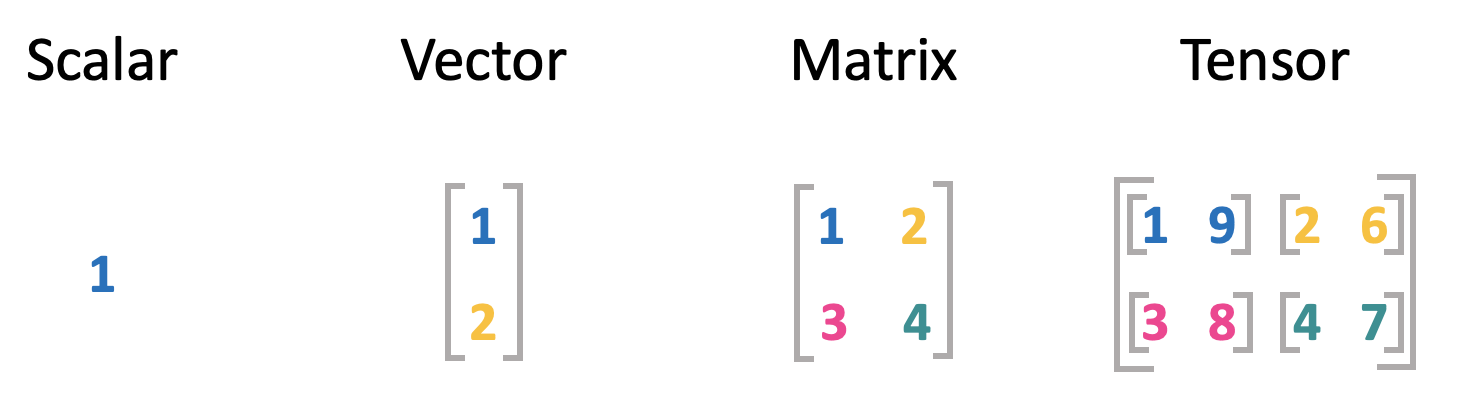

In [18]:
# !pip install tensorly

In [2]:
import numpy as np 
import torch as tl
np.random.seed(1)
import sys 
sys.path.append('../src/')
from lib import*

In [3]:
tensor_scalar = tl.tensor(1)
tensor_vector = tl.tensor([1, 2, 3])
tensor_matrix = tl.tensor([[1, 2, 3], [4, 5, 6]])
tensor_3d = tl.tensor(np.random.rand(3, 4, 5))
tensor_4d = tl.tensor(np.random.rand(3, 4, 5, 6))

print(f" 0 dimensional shape is {tensor_scalar.shape}, the number of its elements is {tensor_scalar.size}, and its order is {tensor_scalar.ndim}")
print(f" 1 dimensional shape is {tensor_vector.shape}, the number of its elements is {tensor_vector.size}, and its order is {tensor_vector.ndim}")
print(f" 2 dimensional shape is {tensor_matrix.shape}, the number of its elements is {tensor_matrix.size}, and its order is {tensor_matrix.ndim}")
print(f" 3 dimensional shape is {tensor_3d.shape}, the number of its elements is {tensor_3d.size}, and its order is {tensor_3d.ndim}")
print(f" 4 dimensional shape is {tensor_4d.shape}, the number of its elements is {tensor_4d.size}, and its order is {tensor_4d.ndim}")


 0 dimensional shape is (), the number of its elements is 1, and its order is 0
 1 dimensional shape is (3,), the number of its elements is 3, and its order is 1
 2 dimensional shape is (2, 3), the number of its elements is 6, and its order is 2
 3 dimensional shape is (3, 4, 5), the number of its elements is 60, and its order is 3
 4 dimensional shape is (3, 4, 5, 6), the number of its elements is 360, and its order is 4


### Problems with high dimensional tensors
- **Curse of dimensionality and Storage**: the number of elements grows exponentially with the order of the tensor
- **Computation**: the number of operations grows exponentially with the order of the tensor
- **Visualization**: it is impossible to visualize tensors with order greater than 3

In [22]:
n,d = 10,1
while d<=10:
    d = d+1
    tensor = n**d
    print(f"For tensor of order {d} which has {n} elements in each dimension, the number of elements is {tensor}")

For tensor of order 2 which has 10 elements in each dimension, the number of elements is 100
For tensor of order 3 which has 10 elements in each dimension, the number of elements is 1000
For tensor of order 4 which has 10 elements in each dimension, the number of elements is 10000
For tensor of order 5 which has 10 elements in each dimension, the number of elements is 100000
For tensor of order 6 which has 10 elements in each dimension, the number of elements is 1000000
For tensor of order 7 which has 10 elements in each dimension, the number of elements is 10000000
For tensor of order 8 which has 10 elements in each dimension, the number of elements is 100000000
For tensor of order 9 which has 10 elements in each dimension, the number of elements is 1000000000
For tensor of order 10 which has 10 elements in each dimension, the number of elements is 10000000000
For tensor of order 11 which has 10 elements in each dimension, the number of elements is 100000000000


## What is a Tensor Train (TT)
- It decomposes a high dimensional tensor into a sequence of 3D tensors, which are called cores (TT-cores). It reduces the computational cost and storage drastically.
- For a tensor $\mathcal{T} \in \mathbb{R}^{n_1 \times n_2 \times \ldots \times n_d}$, its TT-decompositions is: 

$$\mathcal{T}(i_1,...,i_d) = G^{(1)}(i_1) \cdot G^{(2)}(i_2) \cdot \ldots \cdot G^{(d)}(i_d)$$
where each $G^{(k)}$ is a 3D tensor of size $r_{k-1} \times n_k \times r_k$ and $r_0 = r_d = 1$. The numbers $r_k$ are called TT-ranks.



In [23]:
# Reconstruction of the original tensor from a TT-decomposition
d,r = [2,3,4],[1,2,3,1]
# G1 = np.random.randn(r[0],d[0],r[1])
# G2 = np.random.randn(r[1],d[1],r[2])
# G3 = np.random.randn(r[2],d[2],r[3])
G1 = np.arange(r[0]*d[0]*r[1]).reshape(r[0],d[0],r[1])
G2 = np.arange(r[1]*d[1]*r[2]).reshape(r[1],d[1],r[2])
G3 = np.arange(r[2]*d[2]*r[3]).reshape(r[2],d[2],r[3])
tensor_reconstructed_1 = np.einsum("aib,bjc,ckd->ijk", G1, G2, G3)

tensor_reconstruced_2 = np.tensordot(np.tensordot(G1, G2, axes=([2], [0])), G3, axes=([3], [0])).reshape(d[0],d[1],d[2])
print(np.allclose(tensor_reconstructed_1, tensor_reconstruced_2))

print("einsum reconstruction: \n",tensor_reconstructed_1)
print("tensor dot reconstruction: \n",tensor_reconstruced_2)

def reconstruct_from_tt(G):
    tensor_reconstructed = G[0]
    dimensions = [x.shape[1] for x in G]
    for i in range(1, len(G)):
        tensor_reconstructed = np.tensordot(tensor_reconstructed, G[i], axes=([-1], [0]))
    return tensor_reconstructed.reshape(dimensions)
tensor_reconstructed_3 = reconstruct_from_tt([G1, G2, G3])
print(np.allclose(tensor_reconstructed_1, tensor_reconstructed_3))

True
einsum reconstruction: 
 [[[ 128  158  188  218]
  [ 164  203  242  281]
  [ 200  248  296  344]]

 [[ 424  520  616  712]
  [ 604  745  886 1027]
  [ 784  970 1156 1342]]]
tensor dot reconstruction: 
 [[[ 128  158  188  218]
  [ 164  203  242  281]
  [ 200  248  296  344]]

 [[ 424  520  616  712]
  [ 604  745  886 1027]
  [ 784  970 1156 1342]]]
True


## TT-Ranks, Compression

### TT-Ranks
- It controls the storage cost, computational complexity and accuracy of the tensor. Low TT-ranks has efficient representation but low accuracy.
- TT-ranks are the dimensions of the core tensors.
### TT compression
- TT-SVD (sequential SVD-based compression)
- TT-Cross (interpolation-approximation based compression)
### TT_SVD algorithms decomposition
For a tensor $\mathcal{T} \in \mathbb{R}^{n_1 \times n_2 \times \ldots \times n_d}$. To find the core tensors $G^{(k)}$ and the TT-ranks $r_k$,
$$\mathcal{T}(i_1,...,i_d) = G^{(1)}(i_1) \cdot G^{(2)}(i_2) \cdot \ldots \cdot G^{(d)}(i_d)$$
its TT-SVD algorithm is as follow is: 
- **Step 1**: Unfolding into mod-1 tensor 
$\mathcal{T} \rightarrow \mathcal{T}_{(1)} \in \mathbb{R}^{n_1 \times (n_2 \times \ldots \times n_d)}$

- **Step 2**: SVD on mod-1 tensor  
-- $\mathcal{T}_{(1)} = U_1 \Sigma_1 V_1^T$, where $U_1 \in \mathbb{R}^{n_1 \times r_1}$, $\Sigma_1 \in \mathbb{R}^{r_1 \times r_1}$, and $V_1 \in \mathbb{R}^{(n_2 \times \ldots \times n_d) \times r_1}$  
-- $G^{(1)} = $ reshape $U_1 $ into $r_0 \times n_1 \times r_1$ and $\mathcal{T}_{(1)}' = \Sigma_1 \cdot V_1^T$

- **Step 3**: Reshaping into mod-1,2 tensor

-- $\mathcal{T}_{(1)}' \rightarrow \mathcal{T}_{(2)}' \in \mathbb{R}^{(r_1 n_2) \times (n_3 \times \ldots \times n_d)}$ 
- **Step 4**: SVD on mod-1,2 tensor  
-- $\mathcal{T}_{(2)}' = U_2 \Sigma_2 V_2^T$, where $U_2 \in \mathbb{R}^{(r_1 n_2) \times r_2}$, $\Sigma_2 \in \mathbb{R}^{r_2 \times r_2}$, and $V_2 \in \mathbb{R}^{(n_3 \times \ldots \times n_d) \times r_2}$  
-- $G^{(2)} = $ reshape $U_2 $ into $r_1 \times n_2 \times r_2$ and $\mathcal{T}_{(2)}'' = \Sigma_2 \cdot V_2^T$
- **Step 5**: Repeat step 3 and 4 until the last mode

In [24]:
shapes = (3,4,5,6)
tensor = np.arange(np.product(shapes)).reshape(shapes)
rank = 2

modes = len(shapes)

print(f"The shape of the original tensor is {tensor.shape} with number of element {tensor.size}")


The shape of the original tensor is (3, 4, 5, 6) with number of element 360


In [26]:


# SVD implementation 
import numpy as np


def reconstruct_from_tt(tt_cores):
    """
    Reconstructs a full tensor from its TT decomposition.

    Args:
        tt_cores (list of np.ndarray): List of TT cores. Each core has shape (r_prev, d_mode, r_next).

    Returns:
        np.ndarray: Reconstructed full tensor.
    """
    tensor = tt_cores[0]  # Start with first core
    for i in range(1, len(tt_cores)):
        # Contract along the bond dimension
        tensor = np.tensordot(tensor, tt_cores[i], axes=([-1], [0]))
    
    # Get original dimensions from the cores
    dimensions = [core.shape[1] for core in tt_cores]
    return tensor.reshape(dimensions)


def tt_svd(tensor, rank):
    """
    Perform TT-SVD decomposition of a full tensor.

    Args:
        tensor (np.ndarray): Input tensor of shape (d1, d2, ..., dn)
        rank (int or list): TT-ranks; if int, all intermediate ranks are set to this value

    Returns:
        list of np.ndarray: List of TT cores [G1, G2, ..., Gn]
    """
    shape = list(tensor.shape)
    n = len(shape)  # Number of dimensions

    # Handle rank input
    if isinstance(rank, int):
        rank = [rank] * n
    elif len(rank) != n:
        raise ValueError("Length of rank must match number of tensor dimensions.")

    # Prepend and append rank 1 at start/end
    tt_ranks = [1] + rank + [1]

    cores = []
    unfolding = tensor.copy()

    for i in range(n):
        if i==n-1:
            break
        curr_dim = shape[i]
        next_rank = tt_ranks[i + 1]

        # Reshape into matrix
        unfolding = unfolding.reshape(tt_ranks[i] * curr_dim, -1)

        # SVD
        U, S, Vt = np.linalg.svd(unfolding, full_matrices=False)

        # Truncate based on desired rank
        U_trunc = U[:, :next_rank]
        S_trunc = S[:next_rank]
        Vt_trunc = Vt[:next_rank, :]

        # Reshape U into TT-core
        core = U_trunc.reshape(tt_ranks[i], curr_dim, next_rank)
        cores.append(core)

        # Update unfolding with S @ Vt
        unfolding = np.diag(S_trunc) @ Vt_trunc
    unfolding = unfolding.reshape(tt_ranks[-2], shape[-1], tt_ranks[-1])
    cores.append(unfolding)
    return cores
from tensorly.decomposition import tensor_train

tt_tensor = tensor_train(tensor, rank=rank)
G = tt_svd(tensor,rank)
tensor_reconstructed_2 = reconstruct_from_tt(G)
print(f"The shape of the reconstructed tensor is {tensor_reconstructed_2.shape}")
print(f"The error is tensor and tt_svd {np.linalg.norm(tensor - tensor_reconstructed_2)}")

The shape of the reconstructed tensor is (3, 4, 5, 6)
The error is tensor and tt_svd 3.6017122230235946e-12


### Orthogonalization in TT-format
1. Left orthogonalization

We uses **QR** decomposition of the tensor to obtain the left orthogonal components.
All cores left of position k are orthogonal:
$$ \sum_{j=1}^{n_j} G_j(i)^TG_j(i) = I$$
Algorithms:  

Inputs : Cores of the TT-decomposition : $G_1$ (dim: $1\times n_1 \times r_1$), $G_2$(dim: $r_1 \times n_2 \times r_2 $),...  
**a.** Take a core $G_0$ and reshape it into $(1*n_1)\times r_1$  
**b.** Perform **SVD** decomposition( or QR) of current core (here $G_0$), i.e. $G_0=(U_0S_0V_0^T)$ where $Q=U_0:(n_1\times s_1)$ and $R=S_0V_0^T: (s_1 \times r_1)$ and takes the 1st core as $Q:$ reshape$(1,n_1,s_1)$  
**c.** Multiply $R$ to the next cores $G_1$, the result will be of shape $(s_1,n_2,r_2)$.  Reshape it into $(s_1*n_2,r_2)$
**d.** Perform **SVD** decomposition(seen as QR) of current core (here $G_1$), i.e. $G_1=(U_1S_1V_1^T)$ where $Q=U_1:((s_1*n_2)\times s_2)$ and $R=S_1V_1^T: (s_2 \times r_2)$ and takes the 2nd core as $Q:$ reshape$(s_1,n_2,s_2)$
**e.** Multiply $R$ to the next cores $G_2$, the result will be of shape $(s_2,n_3,r_3)$.  Reshape it into $(s_2*n_3,r_3)$
**f.** Repeat the steps until the last core.
The output will be a list of orthogonal cores.


2. Right orthogonalization

We uses **QR** decomposition of the transpose of the tensor to obtain the transpose of orthogonal components.
All cores left of position k are orthogonal:
$$ \sum_{j=1}^{n_j} G_j(i)G_j(i)^T = I$$

In [27]:



# Define TT cores manually
tt_cores = [
    np.random.randn(1, 3, 5),   # Core 0
    np.random.randn(5, 4, 6),   # Core 1
    np.random.randn(6, 2, 1)    # Core 2
]

# Left orthogonalization
tt_cores_left = tt_orthogonalize(tt_cores.copy(), types="svd", left_right="right")

# Right orthogonalization
tt_cores_right = right_orthogonalize(tt_cores.copy())


for core in tt_cores_left:
    print(is_left_orthogonal(core))
tensor_reconstructed_left = reconstruct_from_tt(tt_cores_left)

tensor_reconstructed = reconstruct_from_tt(tt_cores)

error = np.linalg.norm(tensor_reconstructed - tensor_reconstructed_left)
relative_error = error / np.linalg.norm(tensor_reconstructed)

print("Absolute error:", error)
print("Relative error:", relative_error)

# tensor_reconstructed_right = reconstruct_from_tt(tt_cores_right)
# print(f"tensor_reconstructed_right.shape: {tensor_reconstructed_right.shape}")
# error = np.linalg.norm(tensor_reconstructed - tensor_reconstructed_right)
# relative_error = error / np.linalg.norm(tensor_reconstructed)

# print("Absolute error:", error)
# print("Relative error:", relative_error)

TypeError: tt_orthogonalize() got an unexpected keyword argument 'types'

In [ ]:
import tensorly as tl 
# Generate a TT tensor with size 
szY = [5, 6, 7, 8,9, 10]
szY = np.array(szY)

# and TT ranks
rankTT = [1, 2, 3, 4,3, 2, 1]
N = len(szY)

# TT-Tensor Ytt 
Ytt = tl.random.random_tt(shape=szY, rank=rankTT)

print(Ytt)
for n in range(N-1):
    """
    Perform the left orthogonalization on the core tensor n-th Yn of the TT tensor Y

    """
     
    Ytt_o = tt_orth_at(Ytt, n, 'left')

    # Check orthogonality of Ytt_o[n]
    Q = Ytt_o[n].reshape(-1,Ytt_o[n].shape[-1]).T @ Ytt_o[n].reshape(-1,Ytt_o[n].shape[-1])
    print(f'Left-Orthogonalize core {n}: orthogonality error :{np.linalg.norm(Q - np.eye(Ytt_o[n].shape[-1]))}')

factors list : rank-(1, 2, 3, 4, 3, 2, 1) matrix-product-state tensor of shape (5, 6, 7, 8, 9, 10) 
Left-Orthogonalize core 0: orthogonality error :4.3807695049943604e-16
Left-Orthogonalize core 1: orthogonality error :4.975308949793593e-16
Left-Orthogonalize core 2: orthogonality error :1.0021217702272194e-15
Left-Orthogonalize core 3: orthogonality error :5.695747258139164e-16
Left-Orthogonalize core 4: orthogonality error :2.2581277788700136e-16


# DMD with tensor algorithms :


## DMD with tensor algorithms and its Similarity with **DMD** algorithms on matrix:
- Given a sequence of d-dimensional tensors  $X_i​∈\mathbb{R}^{n_1​×n_2​×⋯×_{n_d}}$​, stack them into two large tensor datasets $\mathcal{X}$ and $\mathcal{Y}$.
- Compute a low-rank TT-format decomposition  of these tensor datasets.
- Use properties of the TT-decomposition to compute the pseudoinverse  of the tensor unfolding $\mathcal{X}=\text{matricize}(\mathcal{X})$ without explicitly forming the full matrix.
- Compute the DMD operator $\mathcal{A}=\mathcal{Y}\mathcal{X}^+$, and extract its eigenvalues and eigenvectors — the DMD modes and frequencies.
     

In [ ]:
import tensorly 


TypeError: 'BackendManager' object is not callable

In [ ]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import tensor_train as ttd
# from tensorly.backend import ndarr
from tensorly.tt_tensor import TTTensor
# Example: Simulated 4D tensor data (e.g., 100x100x3 time series images)
snapshots = [np.random.rand(100, 100, 3) for _ in range(100)]  # 100 snapshots of shape (100,100,3)

# Stack into a single tensor: (dim1, dim2, dim3, num_snapshots)
X_data = np.stack(snapshots, axis=-1)  # shape = (100, 100, 3, 100)
Y_data = X_data[..., 1:]              # shifted by one step
X_data = X_data[..., :-1]
# Set TT ranks (example: rank = [1, 10, 10, 10, 1])
ranks = [1, 10, 10, 10, 1]

# Convert X and Y to TT format
X_tt = ttd(X_data, rank=ranks)
Y_tt = ttd(Y_data, rank=ranks)
def tt_unfold(tt_tensor, mode):
    """Matricize a TT-tensor along given mode."""
    full_tensor = tl.tt_to_tensor(tt_tensor)  # Convert to full tensor
    unfolded = tl.unfold(full_tensor, mode=mode)
    return unfolded

# Reshape X and Y as (spatial x time) matrices
X_mat = tt_unfold(X_tt, mode=-1).T  # shape = (100*100*3, 99)
Y_mat = tt_unfold(Y_tt, mode=-1).T  # shape = (100*100*3, 99)

print(f"Shape of X_mat: {X_mat.shape}")
print(f"Shape of Y_mat: {Y_mat.shape}")
# Compute SVD of X_mat (shape: 30000 x 99)
U, S, Vt = np.linalg.svd(X_mat, full_matrices=False)
print("SVD completed.")
S_inv = np.diag(1.0 / S)
X_pinv = Vt.T @ S_inv @ U.T

# Compute A matrix
A = Y_mat @ X_pinv  # shape: (30000, 30000)
print("A cpmpleted")
# Compute eigenvalues and eigenvectors
lambda_, W = np.linalg.eig(A)
print("Eigenvalues and eigenvectors computed.")
# Sort by magnitude
idx = np.argsort(np.abs(lambda_))[::-1]
lambda_ = lambda_[idx]
W = W[:, idx]

# Project back to original space (DMD modes)
modes = U @ W  # shape: (30000, num_modes)

# Reshape each mode into (100, 100, 3)
shape = X_data.shape[:-1]  # (100, 100, 3)
phi_tensors = [modes[:, i].reshape(shape) for i in range(modes.shape[1])]

Shape of X_mat: (30000, 99)
Shape of Y_mat: (30000, 99)
SVD completed.
A cpmpleted


In [ ]:
exact_modes = []
for i in range(num_modes):
    phi_exact = (1 / lambda_[i]) * Y_mat @ Vt.T @ np.diag(1.0 / S) @ W[:, i]
    exact_modes.append(phi_exact.reshape(shape))

In [ ]:
import numpy as np
import tensorly as tl
from tensorly import tt_tensor
from tensorly.tt_matrix import TTMatrix
# from tensorly.backend import ndarr
from tensorly.decomposition import tensor_train as ttd
from scipy.linalg import svd, eig

# Set backend to NumPy
tl.set_backend('numpy')

def tt_unfold(tt, mode):
    """Unfold TT tensor along given mode (without full reconstruction)."""
    return tl.unfold(tt.to_array(), mode=mode)

def tt_left_orthonormalize(tt_cores, idx):
    """Left-orthonormalize up to core idx."""
    for i in range(idx):
        shape = tt_cores[i].shape
        matrix = tt_cores[i].reshape(shape[0] * shape[1], shape[2])
        Q, R = np.linalg.qr(matrix)
        tt_cores[i] = Q.reshape(shape[0], shape[1], Q.shape[1])
        if i + 1 < len(tt_cores):
            tt_cores[i + 1] = np.tensordot(R, tt_cores[i + 1], axes=(1, 0))
    return tt_cores

def tt_right_orthonormalize(tt_cores, idx):
    """Right-orthonormalize from core idx."""
    for i in reversed(range(idx, len(tt_cores))):
        shape = tt_cores[i].shape
        matrix = tt_cores[i].reshape(shape[0], shape[1] * shape[2])
        Q, R = np.linalg.qr(matrix.T)
        Q = Q.T
        tt_cores[i] = Q.reshape(Q.shape[0], shape[1], shape[2])
        if i > 0:
            tt_cores[i - 1] = np.tensordot(tt_cores[i - 1], R.T, axes=(2, 0))
    return tt_cores

def tt_pseudoinverse_core(tt_cores, unfold_mode=-1):
    """
    Approximate pseudoinverse by orthogonalizing and extracting core.
    Assume last mode is time dimension.
    """
    # Left-orthonormalize all except last core
    tt_cores = tt_left_orthonormalize(tt_cores, len(tt_cores) - 1)
    
    # Take SVD of last core
    last_core = tt_cores[-1]
    shape = last_core.shape
    M = last_core.reshape(shape[0] * shape[1], shape[2])
    U, S, Vt = svd(M, full_matrices=False)
    S_inv = np.diag(1.0 / S)

    # Replace last core with U
    new_last_core = U.reshape(shape[0], shape[1], U.shape[1])
    tt_cores[-1] = new_last_core
    
    # Return modified cores and singular values
    return tt_cores, S_inv, Vt, U
def tt_project(Y_cores, X_cores_left, Vt, S_inv):
    """
    Compute Y @ Vt @ S_inv in TT format.
    """
    # Multiply last core of X_cores_left with Vt @ S_inv
    last_X_core = X_cores_left[-1]
    shape = last_X_core.shape
    M = last_X_core.reshape(shape[0] * shape[1], shape[2])
    M_new = M @ Vt.T @ S_inv
    new_last_core = M_new.reshape(shape[0], shape[1], M_new.shape[1])

    # Build projected X core list
    X_proj_cores = X_cores_left[:-1] + [new_last_core]

    # Contract Y with X_proj_cores core-by-core
    A_cores = []
    for i, (y_core, x_core) in enumerate(zip(Y_cores, X_proj_cores)):
        print(f"\ndoing core{i}")
        print(f"Shape of y_core: {y_core.shape}")
        print(f"Shape of x_core: {x_core.shape}")

        # Contract spatial indices j,k; keep left/right ranks i,l
        a_core = np.einsum("ijk,ljk->il", y_core, x_core)
        print(f"Shape of a_core after einsum: {a_core.shape}")
        
        A_cores.append(a_core)

    # Combine into a small matrix A_tilde via sequential multiplication
    A_tilde = A_cores[0]
    print(f"Shape of A_tilde before loop: {A_tilde.shape}")

    for i in range(1, len(A_cores)):
        print(f"Shape of A_tilde before multiplication: {A_tilde.shape}")
        print(f"Shape of A_cores[{i}] before multiplication: {A_cores[i].shape}")

        if A_tilde.shape[1] != A_cores[i].shape[0]:
            print("Using Kronecker product due to shape mismatch")
            A_tilde = np.kron(A_tilde, A_cores[i])
        else:
            A_tilde = A_tilde @ A_cores[i]

        print(f"Shape of A_tilde after multiplication: {A_tilde.shape}")

    return A_tilde

# Example usage:
# ----------------------------------------------------------------------
# Step 1: Load or generate TT tensors
# ----------------------------------------------------------------------
# Assume X_tt and Y_tt are TTTensors of shape (n1, n2, ..., nd, m)
# For example:
# X_tt = ttd(X_data, rank=[1, 10, 10, 10, 1])
x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)
t = np.linspace(0,4*np.pi,3)

# Generate random snapshots
f = lambda x,y,t: np.sin(x)*np.cos(y)*np.sin(t)
snapshots = [np.array([[[i*f(xi,yi,ti) for ti in t ] for yi in y] for xi in x]) for i in range(100)]
# print("shape of snapshots",snapshots.shape)

# snapshots = [np.random.rand(100, 100, 3) for _ in range(100)]  # 100 snapshots of shape (100,100,3)

# Stack into a single tensor: (dim1, dim2, dim3, num_snapshots)
X_data = np.stack(snapshots, axis=-1)  # shape = (100, 100, 3, 100)
Y_data = X_data[..., 1:]              # shifted by one step
X_data = X_data[..., :-1]
# Set TT ranks (example: rank = [1, 10, 10, 10, 1])
ranks = [1, 10, 10, 10, 1]

# Convert X and Y to TT format
X_tt = ttd(X_data, rank=ranks)
Y_tt = ttd(Y_data, rank=ranks)


# Convert to list of cores
X_cores = X_tt.factors
Y_cores = Y_tt.factors

# Step 2: Left/right orthogonalize and extract pseudoinverse info
X_cores_left, S_inv, Vt, U = tt_pseudoinverse_core(X_cores.copy(), unfold_mode=-1)

# Step 3: Project Y onto X's space
A_tilde = tt_project(Y_cores, X_cores_left, Vt, S_inv)

# Step 4: Compute eigenvalues and eigenvectors
# Step 4: Compute eigenvalues and eigenvectors
lambda_, W = eig(A_tilde)

# Step 5: Reconstruct DMD modes in TT format
# For simplicity, back-project using U


# Reconstruct DMD modes using TT cores
def reconstruct_dmd_modes_tt(U, X_cores, k):
    """
    Reconstruct DMD modes by replacing last TT core with U[:, :k]
    """
    phi_tensors = []

    for i in range(k):
        # Take one mode at a time
        mode_vector = U[:, i]

        # Reshape mode_vector to match the last TT core's shape
        last_core_shape = X_cores[-1].shape
        try:
            new_last_core = mode_vector.reshape(last_core_shape)
        except ValueError:
            raise ValueError(f"Cannot reshape {mode_vector.shape} into {last_core_shape}")

        # Build full tensor by contracting all cores
        tt_cores = X_cores[:-1] + [new_last_core]
        
        full_mode = tl.tt_tensor.TTTensor(tt_cores)#.to_array()
        
        # Remove the time dimension before saving
        phi_tensors.append(full_mode)

    return phi_tensors


# Choose top-k modes
k = min(5, U.shape[1], W.shape[0])
modes = U[:, :k] @ W[:k, :k]

# Reconstruct DMD modes using TT decomposition
phi_tensors = reconstruct_dmd_modes_tt(modes, X_cores_left, k=k)

# Now phi_tensors contains proper (100, 100, 3) shaped tensors


Shape of X_data: (100, 100, 3, 99)
Shape of Y_data: (100, 100, 3, 99)
Shape of X_tt: (100, 100, 3, 99)
Shape of Y_tt: (100, 100, 3, 99) 
len of X_cores: 4
len of Y_cores: 4
Shape of X_cores_left: 4
Shape of S_inv: (1, 1)
Shape of Vt: (1, 1)
Shape of U: (990, 1)

doing core0
Shape of y_core: (1, 100, 10)
Shape of x_core: (1, 100, 10)
Shape of a_core after einsum: (1, 1)

doing core1
Shape of y_core: (10, 100, 10)
Shape of x_core: (10, 100, 10)
Shape of a_core after einsum: (10, 10)

doing core2
Shape of y_core: (10, 3, 10)
Shape of x_core: (10, 3, 10)
Shape of a_core after einsum: (10, 10)

doing core3
Shape of y_core: (10, 99, 1)
Shape of x_core: (10, 99, 1)
Shape of a_core after einsum: (10, 10)
Shape of A_tilde before loop: (1, 1)
Shape of A_tilde before multiplication: (1, 1)
Shape of A_cores[1] before multiplication: (10, 10)
Using Kronecker product due to shape mismatch
Shape of A_tilde after multiplication: (10, 10)
Shape of A_tilde before multiplication: (10, 10)
Shape of A_core

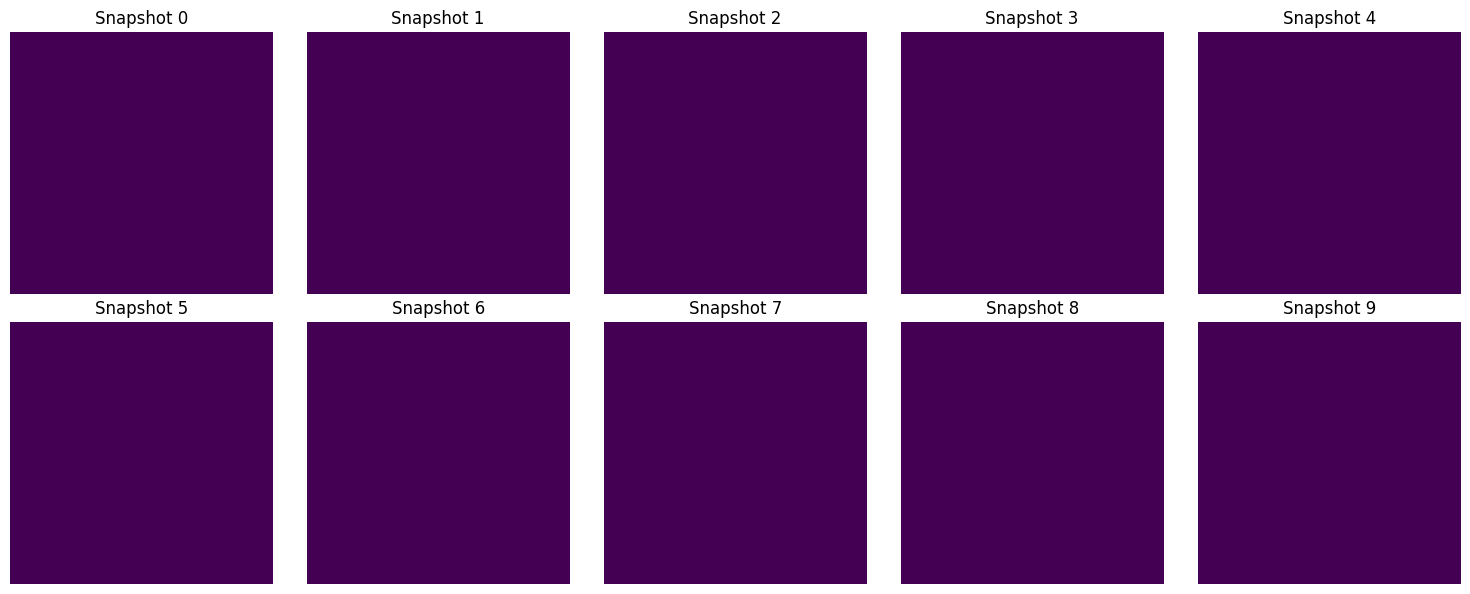

TypeError: list indices must be integers or slices, not tuple

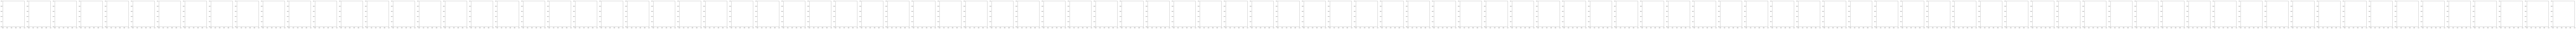

In [ ]:
import matplotlib.pyplot as plt

# Plot first few snapshots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_data[:, :, 0, i], cmap='viridis')
    ax.set_title(f"Snapshot {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()

def plot_dmd_mode(mode_tensor, title="DMD Mode"):
    """Plot a single DMD mode (assumes mode_tensor is TTTensor)"""
    mode_array = mode_tensor#.to_array()  # Convert TT to full array
    num_channels = mode_array.shape[-1]

    fig, axes = plt.subplots(1, num_channels, figsize=(5 * num_channels, 5))
    if num_channels == 1:
        axes = [axes]
    for ch in range(num_channels):
        plt.imshow(mode_array[:, :, 1,ch], cmap='coolwarm')
        axes[ch].set_title(f"Channel {ch+1}")
        axes[ch].axis("off")
        fig.colorbar(im, ax=axes[ch])
        fig.suptitle(title)
        plt.tight_layout()
        plt.show()

# Plot top DMD modes
for i, phi in enumerate(phi_tensors):
    plot_dmd_mode(phi, title=f"DMD Mode {i+1}")
def plot_multiple_dmd_modes(phi_tensors, n_show=5):
    fig, axes = plt.subplots(n_show, 3, figsize=(15, 4 * n_show))
    for i in range(n_show):
        mode_array = phi_tensors[i].to_array()
        for ch in range(3):
            im = axes[i, ch].imshow(mode_array[:, :, ch], cmap='coolwarm')
            axes[i, ch].set_title(f"Mode {i+1}, Channel {ch+1}")
            axes[i, ch].axis("off")
            fig.colorbar(im, ax=axes[i, ch])
    plt.tight_layout()
    plt.show()

plot_multiple_dmd_modes(phi_tensors, n_show=3)
def plot_eigenvalues(lambda_vals, title="DMD Eigenvalues"):
    plt.figure(figsize=(6, 6))
    plt.scatter(lambda_vals.real, lambda_vals.imag, c=np.abs(lambda_vals), cmap='viridis', s=50)
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.title(title)
    plt.grid(True)
    plt.axhline(0, color='black', lw=1)
    plt.axvline(0, color='black', lw=1)
    circle = plt.Circle((0, 0), 1, color='gray', linestyle='--', fill=False)
    plt.gca().add_patch(circle)
    plt.axis("equal")
    plt.show()

plot_eigenvalues(lambda_)

def plot_time_dynamics(W, lambda_vals, timesteps=100):
    dt = 1.0
    t = np.linspace(0, timesteps * dt, timesteps)
    modes_time = np.zeros((timesteps, W.shape[0]), dtype=complex)

    for i, lam in enumerate(lambda_vals):
        omega = np.log(lam) / dt
        modes_time[:, i] = np.exp(omega * t)

    plt.figure(figsize=(10, 4))
    for i in range(modes_time.shape[1]):
        plt.plot(t, modes_time[:, i].real, label=f"Mode {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("DMD Mode Time Evolution")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_time_dynamics(W, lambda_, timesteps=X_data.shape[-1]-1)

from tensorly import unfold

matricized = unfold(X_data, mode=-1)  # Shape: (100*100*3, m)

plt.figure(figsize=(10, 8))
plt.imshow(matricized, aspect='auto', cmap='viridis')
plt.title("Matricized Data (Spatial x Time)")
plt.xlabel("Time")
plt.ylabel("Flattened Spatial Dimensions")
plt.colorbar(label="Intensity")
plt.show()

Creating synthetic test data...
Test data created with shape: (80, 1000, 150)
Starting HODMD-TT Analysis
Input data shape: (80, 1000, 150)
Algorithm 1: TT Decomposition
TT decomposition successful with ranks: [(1, 80, 60), (60, 1000, 60), (60, 150, 1)]
Algorithm 2: Orthogonalization
Orthogonalization completed
Algorithm 3: Pseudo Inverse Computation
Pseudo inverse computed with effective rank: 60
Algorithm 4: DMD Computation
DMD computation completed with 6 modes
Eigenvalue magnitudes range: [0.808705, 0.999998]
Algorithm 5: Data Reconstruction
Reconstruction completed with relative error: 0.129909
Algorithm 6: Quality Assessment
Shape of original tensor: (80, 1000, 150)
Shape of reconstructed tensor: (80, 1000, 150)
Quality Statistics:
  Relative Error: 0.129909
  Energy Ratio: 0.973816
  Correlation: 0.991537
  Stable/Unstable Modes: 6/0


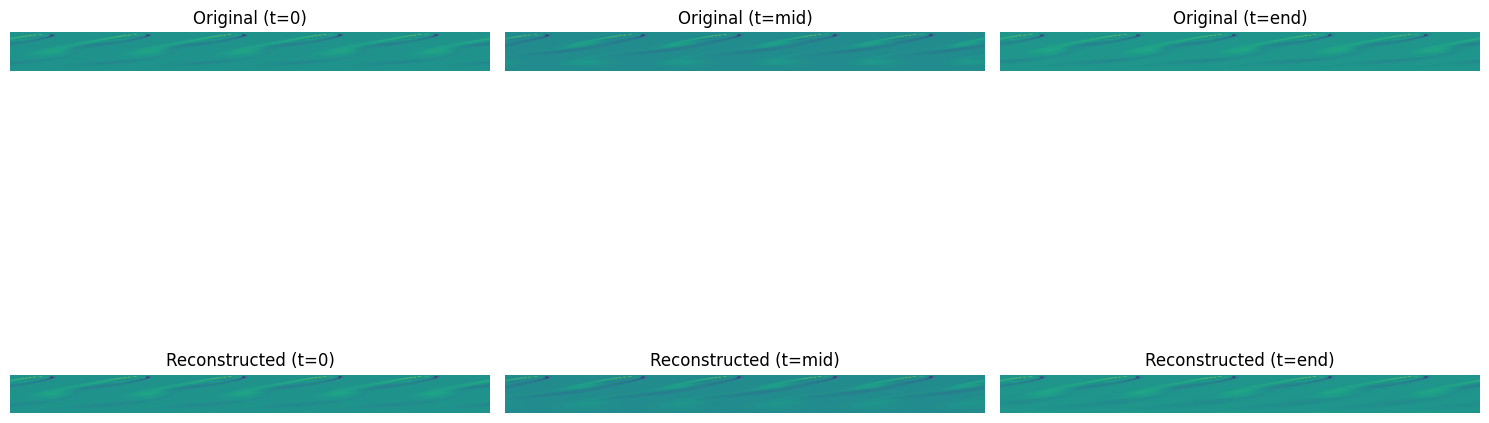

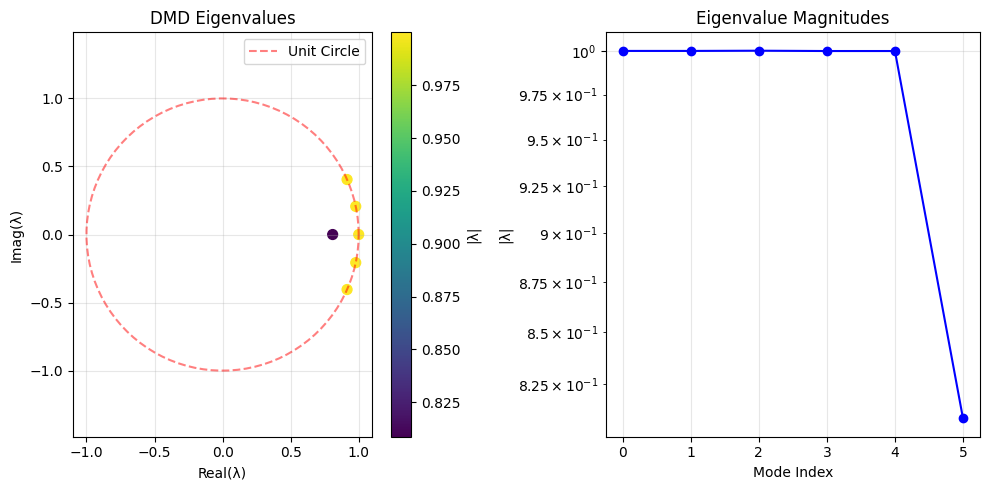


HODMD-TT Analysis Complete!


In [ ]:


# Example usage and test
def create_test_data():
    """Create synthetic spatiotemporal data for testing"""
    print("Creating synthetic test data...")
    
    # Spatial grid
    # x = np.linspace(0, 4*np.pi, 20)
    # y = np.linspace(0, 4*np.pi, 20)
    # X, Y = np.meshgrid(x, y)
    
    # # Time vector
    # t = np.linspace(0, 10, 1000)
    
    # # Create tensor data with multiple modes
    # f = np.zeros((20, 20, 1000))
    
    # # Mode 1: Traveling wave
    # for i, time in enumerate(t):
    #     f[:, :, i] += np.sin(X - 0.5*time) * np.cos(Y)
    
    # # Mode 2: Decaying oscillation
    # for i, time in enumerate(t):
    #     f[:, :, i] += 0.5 * np.exp(-0.1*time) * np.cos(2*X + time) * np.sin(Y)
    
    # # Mode 3: Growing instability (small amplitude)
    # for i, time in enumerate(t):
    #     f[:, :, i] += 0.1 * np.exp(0.05*time) * np.sin(X + Y + 2*time)
    
    # # Add some noise
    # f += 0.05 * np.random.randn(*f.shape)
    from scipy import io 
    vortal_matt = io.loadmat('../dataset/VORTALL.mat')
    f = vortal_matt['VORTALL'][:80000,:150].reshape(80,1000,150)
    print(f"Test data created with shape: {f.shape}")
    return f

# Run example

if __name__ == "__main__":
    # Create test data
    # Create your data (20×20×1000 tensor)


    test_data = create_test_data()
    
    # Initialize HODMD-TT
    hodmd = HODMD_TT(rank=60, svd_rank=100)
    
    # Fit the model
    reconstructed_data, quality_stats = hodmd.fit(test_data)
    
    # Visualize results
    hodmd.visualize_results(test_data, reconstructed_data, quality_stats)
    
    print("\nHODMD-TT Analysis Complete!")
    print("=" * 50)

In [ ]:

import pydmd
from scipy import io 
reconstructed_data = reconstructed_data.reshape(80*1000, 150)
vortal_matt = io.loadmat('../dataset/VORTALL.mat')
X = vortal_matt['VORTALL'][:80000,:150]
dmd = pydmd.HODMD(svd_rank=100, exact=True, opt=True)
dmd.fit(X)

print(dmd.reconstructed_data.shape)
print(np.linalg.norm(dmd.reconstructed_data - reconstructed_data))
print(np.linalg.norm(dmd.reconstructed_data - X))
print(np.linalg.norm(reconstructed_data - X))

# Initialize the DMD_TT class with GPU support and double precision
dmd_tt = DMD_TT(gpu=True, precision='double')

# Perform benchmark analysis with a specified rank list
reconstructed_data, stats = dmd_tt.benchmark_analysis(X, rank_list=np.arange(2, 100, 20))

# Visualize the results
dmd_tt.visualize_results()


(80000, 150)
526.2997495552258
0.005525080172117079
526.2997502716257


In [ ]:

# class DMD_TT:
#     """
#     Higher-Order Dynamic Mode Decomposition using Tensor Train decomposition
#     """
    
#     def __init__(self, rank=None, svd_rank=None):
#         """
#         Initialize HODMD with TT decomposition
        
#         Parameters:
#         -----------
#         rank : list or int
#             TT ranks for decomposition
#         svd_rank : int
#             SVD rank for DMD computation
#         """
#         self.rank = rank
#         self.svd_rank = svd_rank
#         self.tt_cores = None
#         self.dmd_modes = None
#         self.eigenvalues = None
#         self.reconstruction_error = None
        
#     def tensorize_data(self, f):
#         """
#         Convert 3D data to tensor format
        
#         Parameters:
#         -----------
#         f : np.ndarray
#             Input data of shape (nx, ny, nt)
            
#         Returns:
#         --------
#         tensor : np.ndarray
#             Tensorized data
#         """
#         print(f"Input data shape: {f.shape}")
#         return f
    
#     def algorithm1_tt_decomposition(self, tensor):
#         """
#         Algorithm 1: Convert tensor into TT-format using low-rank decomposition
        
#         Parameters:
#         -----------
#         tensor : np.ndarray
#             Input tensor
            
#         Returns:
#         --------
#         tt_cores : list
#             List of TT cores
#         """
#         print("Algorithm 1: TT Decomposition")
        
#         # Set default ranks if not provided
#         if self.rank is None:
#             # Adaptive rank selection based on tensor dimensions
#             dims = tensor.shape
#             max_rank = min(50, min(dims)//2)
#             self.rank = [1] + [max_rank] * (len(dims)-1) + [1]
        
#         # Perform TT decomposition using tensorly
#         try:
#             tt_tensor = tensor_train(tensor, rank=self.rank)
#             self.tt_cores = tt_tensor.factors
#             print(f"TT decomposition successful with ranks: {[core.shape for core in self.tt_cores]}")
#             return self.tt_cores
#         except Exception as e:
#             print(f"TensorLy decomposition failed, using manual SVD-based approach: {e}")
#             return self._manual_tt_decomposition(tensor)
    
#     def _manual_tt_decomposition(self, tensor):
#         """
#         Manual TT decomposition using SVD
#         """
#         cores = []
#         current_tensor = tensor.copy()
        
#         for i in range(len(tensor.shape) - 1):
#             # Reshape for SVD
#             shape = current_tensor.shape
#             matrix = current_tensor.reshape(shape[0], -1)
            
#             # SVD
#             U, s, Vt = svd(matrix, full_matrices=False)
            
#             # Determine rank
#             if isinstance(self.rank, list):
#                 r = min(self.rank[i+1], len(s))
#             else:
#                 r = min(self.rank or 10, len(s))
            
#             # Truncate
#             U = U[:, :r]
#             s = s[:r]
#             Vt = Vt[:r, :]
            
#             # Store core
#             if i == 0:
#                 cores.append(U.reshape(1, shape[0], r))
#             else:
#                 cores.append(U.reshape(U.shape[0], shape[0]//U.shape[0], r))
            
#             # Update tensor for next iteration
#             current_tensor = (np.diag(s) @ Vt).reshape((r,) + shape[1:])
        
#         # Last core
#         cores.append(current_tensor.reshape(current_tensor.shape + (1,)))
        
#         self.tt_cores = cores
#         print(f"Manual TT decomposition completed with {len(cores)} cores")
#         return cores
    
#     def algorithm2_orthogonalization(self, tt_cores):
#         """
#         Algorithm 2: Left and right orthogonalization of TT cores
        
#         Parameters:
#         -----------
#         tt_cores : list
#             List of TT cores
            
#         Returns:
#         --------
#         left_ortho_cores : list
#             Left-orthogonalized cores
#         right_ortho_cores : list
#             Right-orthogonalized cores
#         """
#         print("Algorithm 2: Orthogonalization")
        
#         n_cores = len(tt_cores)
#         left_ortho_cores = [None] * n_cores
#         right_ortho_cores = [None] * n_cores
        
#         # Left orthogonalization
#         for i in range(n_cores - 1):
#             core = tt_cores[i]
#             r_left, n_i, r_right = core.shape
            
#             # Reshape for QR decomposition
#             matrix = core.reshape(r_left * n_i, r_right)
#             Q, R = qr(matrix, mode='economic')
            
#             # Update current core
#             left_ortho_cores[i] = Q.reshape(r_left, n_i, Q.shape[1])
            
#             # Update next core
#             if i < n_cores - 1:
#                 next_core = tt_cores[i + 1]
#                 r_left_next, n_next, r_right_next = next_core.shape
#                 next_matrix = next_core.reshape(r_left_next, n_next * r_right_next)
#                 updated_next = R @ next_matrix
#                 tt_cores[i + 1] = updated_next.reshape(R.shape[0], n_next, r_right_next)
        
#         left_ortho_cores[-1] = tt_cores[-1]
        
#         # Right orthogonalization
#         tt_cores_copy = [core.copy() for core in left_ortho_cores]
        
#         for i in range(n_cores - 1, 0, -1):
#             core = tt_cores_copy[i]
#             r_left, n_i, r_right = core.shape
            
#             # Reshape for QR decomposition
#             matrix = core.reshape(r_left, n_i * r_right)
#             Q, R = qr(matrix.T, mode='economic')
#             Q = Q.T
#             R = R.T
            
#             # Update current core
#             right_ortho_cores[i] = Q.reshape(Q.shape[0], n_i, r_right)
            
#             # Update previous core
#             if i > 0:
#                 prev_core = tt_cores_copy[i - 1]
#                 r_left_prev, n_prev, r_right_prev = prev_core.shape
#                 prev_matrix = prev_core.reshape(r_left_prev * n_prev, r_right_prev)
#                 updated_prev = prev_matrix @ R
#                 tt_cores_copy[i - 1] = updated_prev.reshape(r_left_prev, n_prev, R.shape[1])
        
#         right_ortho_cores[0] = tt_cores_copy[0]
        
#         print("Orthogonalization completed")
#         return left_ortho_cores, right_ortho_cores
    
#     def algorithm3_pseudo_inverse(self, left_cores, right_cores):
#         """
#         Algorithm 3: Pseudo inverse of matricization of TT-cores tensor
        
#         Parameters:
#         -----------
#         left_cores : list
#             Left-orthogonalized cores
#         right_cores : list
#             Right-orthogonalized cores
            
#         Returns:
#         --------
#         pseudo_inv : np.ndarray
#             Pseudo inverse matrix
#         """
#         print("Algorithm 3: Pseudo Inverse Computation")
        
#         n_cores = len(left_cores)
#         middle_idx = n_cores // 2
        
#         # SVD on middle core
#         middle_core = left_cores[middle_idx]
#         r_left, n_i, r_right = middle_core.shape
#         matrix = middle_core.reshape(r_left, n_i * r_right)
        
#         U, s, Vt = svd(matrix, full_matrices=False)
        
#         # Truncate based on svd_rank
#         if self.svd_rank:
#             rank = min(self.svd_rank, len(s))
#             U = U[:, :rank]
#             s = s[:rank]
#             Vt = Vt[:rank, :]
        
#         # Compute pseudo inverse
#         s_inv = np.zeros_like(s)
#         s_inv[s > 1e-12] = 1.0 / s[s > 1e-12]
#         pseudo_inv = Vt.T @ np.diag(s_inv) @ U.T
        
#         print(f"Pseudo inverse computed with effective rank: {np.sum(s > 1e-12)}")
#         return pseudo_inv, U, s, Vt
    
#     def algorithm4_dmd_computation(self, tensor, pseudo_inv_data):
#         """
#         Algorithm 4: Computation of DMD modes and eigenvalues in TT-format
        
#         Parameters:
#         -----------
#         tensor : np.ndarray
#             Original tensor
#         pseudo_inv_data : tuple
#             Pseudo inverse computation results
            
#         Returns:
#         --------
#         eigenvalues : np.ndarray
#             DMD eigenvalues
#         modes : np.ndarray
#             DMD modes
#         """
#         print("Algorithm 4: DMD Computation")
        
#         pseudo_inv, U, s, Vt = pseudo_inv_data
        
#         # Create data matrices for DMD
#         nx, ny, nt = tensor.shape
        
#         # Reshape tensor to matrix form for DMD
#         X = tensor.reshape(nx * ny, nt)
#         X1 = X[:, :-1]  # Data matrix
#         X2 = X[:, 1:]   # Shifted data matrix
        
#         # DMD computation
#         # Compute A_tilde = U^T * X2 * X1^T * U * S^{-1}
#         try:
#             # SVD of X1 for better numerical stability
#             U_x, s_x, Vt_x = svd(X1, full_matrices=False)
            
#             # Truncate based on energy or rank
#             energy_threshold = 0.99
#             cumulative_energy = np.cumsum(s_x**2) / np.sum(s_x**2)
#             effective_rank = np.argmax(cumulative_energy >= energy_threshold) + 1
#             effective_rank = min(effective_rank, len(s_x))
            
#             U_x = U_x[:, :effective_rank]
#             s_x = s_x[:effective_rank]
#             Vt_x = Vt_x[:effective_rank, :]
            
#             # Compute reduced-order DMD
#             A_tilde = U_x.T @ X2 @ Vt_x.T @ np.diag(1.0/s_x)
            
#             # Eigendecomposition
#             eigenvalues, eigenvectors = np.linalg.eig(A_tilde)
            
#             # Compute DMD modes
#             modes = X2 @ Vt_x.T @ np.diag(1.0/s_x) @ eigenvectors
            
#             print(f"DMD computation completed with {len(eigenvalues)} modes")
#             print(f"Eigenvalue magnitudes range: [{np.min(np.abs(eigenvalues)):.6f}, {np.max(np.abs(eigenvalues)):.6f}]")
            
#         except Exception as e:
#             print(f"Advanced DMD failed, using simple approach: {e}")
#             # Fallback to simple DMD
#             A_approx = X2 @ pinv(X1)
#             eigenvalues, modes = eigs(A_approx, k=min(10, min(X1.shape)-1))
        
#         self.eigenvalues = eigenvalues
#         self.dmd_modes = modes
        
#         return eigenvalues, modes
    
#     def algorithm5_reconstruction(self, original_tensor, modes, eigenvalues, dt=1.0):
#         """
#         Algorithm 5: Reconstruction of data and visualization
        
#         Parameters:
#         -----------
#         original_tensor : np.ndarray
#             Original tensor data
#         modes : np.ndarray
#             DMD modes
#         eigenvalues : np.ndarray
#             DMD eigenvalues
#         dt : float
#             Time step
            
#         Returns:
#         --------
#         reconstructed_tensor : np.ndarray
#             Reconstructed tensor
#         """
#         print("Algorithm 5: Data Reconstruction")
        
#         nx, ny, nt = original_tensor.shape
        
#         # Time vector
#         t = np.arange(nt) * dt
        
#         # Compute time dynamics
#         time_dynamics = np.zeros((len(eigenvalues), nt), dtype=complex)
#         for i, lam in enumerate(eigenvalues):
#             time_dynamics[i, :] = np.power(lam, t)
        
#         # Initial conditions (project first snapshot onto modes)
#         X_flat = original_tensor.reshape(nx * ny, nt)
#         b = pinv(modes) @ X_flat[:, 0]
        
#         # Reconstruct
#         X_dmd = modes @ np.diag(b) @ time_dynamics
        
#         # Take real part and reshape
#         X_reconstructed = np.real(X_dmd).reshape(nx, ny, nt)
        
#         # Compute reconstruction error
#         self.reconstruction_error = np.linalg.norm(original_tensor - X_reconstructed) / np.linalg.norm(original_tensor)
        
#         print(f"Reconstruction completed with relative error: {self.reconstruction_error:.6f}")
        
#         return X_reconstructed
    
#     def algorithm6_statistics(self, original_tensor, reconstructed_tensor):
#         """
#         Algorithm 6: Statistics to assess reconstruction quality
        
#         Parameters:
#         -----------
#         original_tensor : np.ndarray
#             Original tensor
#         reconstructed_tensor : np.ndarray
#             Reconstructed tensor
            
#         Returns:
#         --------
#         stats : dict
#             Dictionary containing various quality metrics
#         """
#         print("Algorithm 6: Quality Assessment")
        
#         # Various error metrics
#         print(f"Shape of original tensor: {original_tensor.shape}")
#         print(f"Shape of reconstructed tensor: {reconstructed_tensor.shape}")
#         frobenius_error = np.linalg.norm(original_tensor - reconstructed_tensor)
#         relative_error = frobenius_error / np.linalg.norm(original_tensor)
        
#         # Energy preservation
#         original_energy = np.sum(original_tensor**2)
#         reconstructed_energy = np.sum(reconstructed_tensor**2)
#         energy_ratio = reconstructed_energy / original_energy
        
#         # Correlation coefficient
#         orig_flat = original_tensor.flatten()
#         recon_flat = reconstructed_tensor.flatten()
#         correlation = np.corrcoef(orig_flat, recon_flat)[0, 1]
        
#         # Eigenvalue analysis
#         stable_modes = np.sum(np.abs(self.eigenvalues) <= 1.0)
#         unstable_modes = np.sum(np.abs(self.eigenvalues) > 1.0)
        
#         stats = {
#             'frobenius_error': frobenius_error,
#             'relative_error': relative_error,
#             'energy_ratio': energy_ratio,
#             'correlation': correlation,
#             'stable_modes': stable_modes,
#             'unstable_modes': unstable_modes,
#             'total_modes': len(self.eigenvalues),
#             'effective_rank': np.sum(np.abs(self.eigenvalues) > 1e-10)
#         }
        
#         print(f"Quality Statistics:")
#         print(f"  Relative Error: {relative_error:.6f}")
#         print(f"  Energy Ratio: {energy_ratio:.6f}")
#         print(f"  Correlation: {correlation:.6f}")
#         print(f"  Stable/Unstable Modes: {stable_modes}/{unstable_modes}")
        
#         return stats
    
#     def fit(self, f):
#         """
#         Complete HODMD-TT pipeline
        
#         Parameters:
#         -----------
#         f : np.ndarray
#             Input tensor of shape (nx, ny, nt)
            
#         Returns:
#         --------
#         reconstructed : np.ndarray
#             Reconstructed tensor
#         stats : dict
#             Quality statistics
#         """
#         print("Starting HODMD-TT Analysis")
#         print("=" * 50)
        
#         # Algorithm 1: TT Decomposition
#         tensor = self.tensorize_data(f)
#         tt_cores = self.algorithm1_tt_decomposition(tensor)
        
#         # Algorithm 2: Orthogonalization
#         left_cores, right_cores = self.algorithm2_orthogonalization(tt_cores)
        
#         # Algorithm 3: Pseudo Inverse
#         pseudo_inv_data = self.algorithm3_pseudo_inverse(left_cores, right_cores)
        
#         # Algorithm 4: DMD Computation
#         eigenvalues, modes = self.algorithm4_dmd_computation(tensor, pseudo_inv_data)
        
#         # Algorithm 5: Reconstruction
#         reconstructed = self.algorithm5_reconstruction(tensor, modes, eigenvalues)
        
#         # Algorithm 6: Statistics
#         stats = self.algorithm6_statistics(tensor, reconstructed)
        
#         return reconstructed, stats
    
#     def visualize_results(self, figsize=(20, 20)):
#         """Comprehensive visualization of HODMD/DMD results including error, eigenvalues, amplitudes, and statistics."""
#         if self.reconstructed_data is None:
#             self.predict()
        
#         fig = plt.figure(figsize=figsize)

#         # Original and reconstructed data
#         ax1 = plt.subplot(3, 3, 1)
#         plt.contourf(np.real(np.reshape(self.original_data[:,0],(449,199))).T, levels = 1001, vmin=-2, vmax=2)
#         plt.scatter(50,100,900,color='white', zorder=2) # draw cylinder
#         plt.title('Original Data')
#         plt.ylabel('Spatial Mode')
#         plt.xlabel('Time')

#         ax2 = plt.subplot(3, 3, 2)
#         plt.contourf(np.real(np.reshape(self.reconstructed_data[:,0],(449,199))).T, levels = 1001, vmin=-2, vmax=2)
#         plt.scatter(50,100,900,color='white', zorder=2) # draw cylinder
#         plt.title('Reconstructed Data by DMD matrix')
#         plt.ylabel('Spatial Mode')
#         plt.xlabel('Time')

#         ax3 = plt.subplot(3, 3, 3)
#         error_data = self.original_data - self.reconstructed_data
#         im3 = plt.imshow(error_data, aspect='auto', cmap='RdBu_r')
#         plt.title('Reconstruction Error')
#         plt.ylabel('Spatial Mode')
#         plt.colorbar(im3)

#         # Eigenvalue plot
#         ax4 = plt.subplot(3, 3, 4)
#         plt.scatter(np.real(self.eigenvalues), np.imag(self.eigenvalues),
#                     c=np.abs(self.eigenvalues), cmap='plasma', s=60, alpha=0.7)
#         plt.colorbar(label='|λ|')
#         theta = np.linspace(0, 2*np.pi, 100)
#         plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5, label='Unit Circle')
#         plt.xlabel('Real(λ)')
#         plt.ylabel('Imag(λ)')
#         plt.title('Eigenvalues')
#         plt.grid(True, alpha=0.3)
#         plt.legend()
#         plt.axis('equal')

#         # Mode amplitudes
#         ax5 = plt.subplot(3, 3, 5)
#         plt.semilogy(np.abs(self.amplitudes), 'bo-', markersize=4)
#         plt.xlabel('Mode Index')
#         plt.ylabel('|Amplitude|')
#         plt.title('Mode Amplitudes')
#         plt.grid(True, alpha=0.3)

#         # Time series comparison
#         ax6 = plt.subplot(3, 3, 6)
#         mid_spatial = self.original_data.shape[0] // 2
#         plt.plot(self.original_data[mid_spatial, :], 'b-', label='Original', alpha=0.7)
#         plt.plot(self.reconstructed_data[mid_spatial, :], 'r--', label='Reconstructed', alpha=0.7)
#         plt.xlabel('Time')
#         plt.ylabel('Amplitude')
#         plt.title(f'Time Series (Spatial Mode {mid_spatial})')
#         plt.legend()
#         plt.grid(True, alpha=0.3)

#         # Rank vs Accuracy (MSE)
#         ax7 = plt.subplot(3, 3, 7)
#         if hasattr(self, 'benchmark_data') and 'rank' in self.benchmark_data:
#             ranks = self.benchmark_data['rank']
#             mses = self.benchmark_data['rmse']
#             plt.plot(ranks, mses, 'go-', lw=2)
#             plt.xlabel('SVD Rank')
#             plt.ylabel('RMSE')
#             plt.title('Rank vs Accuracy (RMSE)')
#             plt.grid(True, alpha=0.3)
#             plt.yscale("log")

#         # Speed vs Accuracy (GPU only)
#         ax8 = plt.subplot(3, 3, 8)
#         if hasattr(self, 'benchmark_data') and 'time' in self.benchmark_data:
#             times = self.benchmark_data['time']
#             mses = self.benchmark_data['rmse']
#             plt.plot(times, mses, 'mo-', lw=2)
#             plt.xlabel('Time (s)')
#             plt.ylabel('MSE')
#             plt.title('Speed vs Accuracy')
#             plt.grid(True, alpha=0.3)
#             plt.yscale("log")

#         # Rank vs Speed
#         ax9 = plt.subplot(3, 3, 9)
#         if hasattr(self, 'benchmark_data') and 'time' in self.benchmark_data:
#             ranks = self.benchmark_data['rank']
#             times = self.benchmark_data['time']
#             plt.plot(ranks, times, 'co-', lw=2)
#             plt.xlabel('SVD Rank')
#             plt.ylabel('Time (s)')
#             plt.title('Rank vs Computation Time')
#             plt.grid(True, alpha=0.3)

#         plt.tight_layout()
#         plt.show()
#     def benchmark_analysis(self, X, rank_list=None):
#         """
#         Benchmark DMD/HODMD at different SVD ranks.
        
#         Parameters:
#         -----------
#         X : np.ndarray
#             Input data matrix
#         rank_list : list
#             List of SVD ranks to test
        
#         Returns:
#         --------
#         dict with keys: 'rank', 'mse', 'rmse', 'time'
#         """
#         if rank_list is None:
#             rank_list = [1, 2, 5, 10, 20, 50]
        
#         benchmark_data = {
#             'rank': [],
#             'mse': [],
#             'rmse': [],
#             'time': []
#         }

#         print("Starting benchmark analysis...")
#         for rank in rank_list:
#             print(f"Testing SVD rank: {rank}")
#             self.svd_rank = rank
#             start_time = time.time()
#             self.fit(X)
#             self.predict()
#             stats = self.compute_statistics()
#             elapsed = time.time() - start_time
            
#             benchmark_data['rank'].append(rank)
#             benchmark_data['mse'].append(stats['mse'])
#             benchmark_data['rmse'].append(stats['rmse'])
#             benchmark_data['time'].append(elapsed)

#         self.benchmark_data = benchmark_data
#         print("Benchmark completed.")
#         return benchmark_data


In [ ]:
import numpy as np
import torch
import time
from scipy.linalg import svd, qr, eig, pinv
from scipy.sparse.linalg import eigs
from tensorly.decomposition import tensor_train
from tensorly import backend as T
import matplotlib.pyplot as plt

# Check if PyTorch is available
TORCH_AVAILABLE = True

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Union, List, Optional, Tuple, Dict, Any
import warnings

# Optional GPU and advanced tensor support
try:
    import torch
    import tensorly as tl
    HAS_TORCH = True
except ImportError:
    HAS_TORCH = False
    warnings.warn("PyTorch and/or Tensorly not available. GPU acceleration disabled.")

try:
    from scipy.linalg import svd, pinv, qr
    from scipy.sparse.linalg import svds
    HAS_SCIPY = True
except ImportError:
    HAS_SCIPY = False
    warnings.warn("SciPy not available. Some functionality may be limited.")


class DMD_TT:
    """
    Tensor Train Dynamic Mode Decomposition (TT-DMD) and Higher-Order DMD implementation.
    
    This class implements efficient DMD for high-dimensional tensor data using Tensor Train 
    decomposition to reduce computational complexity from exponential to linear scaling.
    
    Parameters:
    -----------
    svd_ranks : int or None
        SVD truncation rank for dimensionality reduction
    tt_ranks : int or list
        TT-ranks for tensor train decomposition. If int, same rank for all cores.
        If list, should have length d-1 where d is tensor order.
    precision : str
        Numerical precision: "single" or "double"
    gpu : bool
        Whether to use GPU acceleration (requires PyTorch)
    """
    
    def __init__(self, svd_ranks: Optional[int] = None, 
                 tt_ranks: Union[int, List[int]] = 10,
                 precision: str = "double",
                 gpu: bool = False):
        
        self.svd_ranks = svd_ranks
        self.tt_ranks = tt_ranks
        self.precision = precision
        self.gpu = gpu and HAS_TORCH
        
        # Initialize core attributes
        self.tensor_shape = None
        self.tt_cores = None
        self.eigenvalues = None
        self.modes = None
        self.amplitudes = None
        self.reconstructed_data = None
        self.original_data = None
        self.benchmark_data = {}
        
        # Setup precision and device
        self._setup_precision()
        self._setup_device()
        
        # Configure tensorly backend if available
        if self.gpu and HAS_TORCH:
            tl.set_backend('pytorch')
        
    def _setup_precision(self):
        """Setup numerical precision for computations."""
        if self.precision == "single":
            self.dtype_real = np.float32
            self.dtype_complex = np.complex64
            if self.gpu and HAS_TORCH:
                self.torch_dtype_real = torch.float32
                self.torch_dtype_complex = torch.complex64
        else:  # double precision
            self.dtype_real = np.float64
            self.dtype_complex = np.complex128
            if self.gpu and HAS_TORCH:
                self.torch_dtype_real = torch.float64
                self.torch_dtype_complex = torch.complex128
    
    def _setup_device(self):
        """Setup compute device (CPU/GPU)."""
        if self.gpu and HAS_TORCH:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            if not torch.cuda.is_available():
                warnings.warn("GPU requested but CUDA not available. Using CPU.")
                self.gpu = False
        else:
            self.device = None
    
    def _to_tensor(self, array: np.ndarray) -> Union[np.ndarray, 'torch.Tensor']:
        """Convert numpy array to torch tensor with proper device and dtype."""
        if self.gpu and HAS_TORCH:
            if np.iscomplexobj(array):
                return torch.tensor(array, dtype=self.torch_dtype_complex, device=self.device)
            else:
                return torch.tensor(array, dtype=self.torch_dtype_real, device=self.device)
        return array.astype(self.dtype_complex if np.iscomplexobj(array) else self.dtype_real)
    
    def _to_numpy(self, tensor: Union[np.ndarray, 'torch.Tensor']) -> np.ndarray:
        """Convert torch tensor to numpy array."""
        if self.gpu and HAS_TORCH and isinstance(tensor, torch.Tensor):
            return tensor.detach().cpu().numpy()
        return tensor
    
    def _svd_decomposition(self, matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Perform SVD decomposition with optional rank truncation."""
        if self.gpu and HAS_TORCH:
            matrix_torch = self._to_tensor(matrix)
            U, S, Vh = torch.linalg.svd(matrix_torch, full_matrices=False)
            U, S, Vh = self._to_numpy(U), self._to_numpy(S), self._to_numpy(Vh)
        else:
            if HAS_SCIPY and self.svd_ranks and self.svd_ranks < min(matrix.shape):
                U, S, Vh = svds(matrix, k=self.svd_ranks)
                # Sort by descending singular values
                idx = np.argsort(S)[::-1]
                U, S, Vh = U[:, idx], S[idx], Vh[idx, :]
            else:
                U, S, Vh = svd(matrix, full_matrices=False)
        
        # Truncate if rank specified
        if self.svd_ranks:
            rank = min(self.svd_ranks, len(S))
            U, S, Vh = U[:, :rank], S[:rank], Vh[:rank, :]
        
        return U, S, Vh
    
    def tensorize_data(self, f: np.ndarray) -> np.ndarray:
        """
        Convert multi-dimensional data to tensor format.
        
        Parameters:
        -----------
        f : np.ndarray
            Input data. Can be 2D (matrix), 3D (images), 4D (videos), etc.
            Last dimension is assumed to be time.
        
        Returns:
        --------
        tensor : np.ndarray
            Tensorized data ready for TT decomposition
        """
        if f.ndim == 2:
            # Standard DMD case - reshape to 3D tensor
            n_space, n_time = f.shape
            # Create a reasonable tensor shape for spatial dimensions
            factors = self._factorize_dimension(n_space)
            tensor_shape = factors + [n_time]
            tensor = f.reshape(tensor_shape)
        else:
            # Already a tensor
            tensor = f
        
        self.tensor_shape = tensor.shape
        self.original_data = f
        return self._to_tensor(tensor)
    
    def _factorize_dimension(self, n: int) -> List[int]:
        """Factorize dimension into reasonable tensor modes."""
        factors = []
        temp_n = n
        
        # Try to find factors starting from small primes
        for factor in [2, 3, 5, 7, 11, 13]:
            while temp_n % factor == 0:
                factors.append(factor)
                temp_n //= factor
        
        if temp_n > 1:
            factors.append(temp_n)
        
        # If we have too many small factors, combine some
        while len(factors) > 6:  # Limit tensor order
            factors[0] *= factors[1]
            factors.pop(1)
        
        return factors
    
    def algorithm1_tt_decomposition(self, tensor: np.ndarray) -> List[np.ndarray]:
        """
        Algorithm 1: Convert tensor into TT-format using low-rank decomposition.
        
        Implements the TT-SVD algorithm for efficient tensor decomposition.
        """
        tensor = self._to_numpy(tensor)
        d = tensor.ndim  # tensor order
        n = tensor.shape  # mode sizes
        
        # Handle tt_ranks input
        if isinstance(self.tt_ranks, int):
            ranks = [1] + [self.tt_ranks] * (d - 1) + [1]
        else:
            ranks = [1] + list(self.tt_ranks) + [1]
            if len(ranks) != d + 1:
                raise ValueError(f"tt_ranks length {len(self.tt_ranks)} should be {d-1}")
        
        # TT-SVD algorithm
        tt_cores = []
        C = tensor.copy()
        
        for k in range(d - 1):
            # Reshape C to matrix
            C_mat = C.reshape(ranks[k] * n[k], -1)
            
            # SVD decomposition
            U, S, Vh = self._svd_decomposition(C_mat)
            
            # Truncate to desired TT rank
            r = min(ranks[k + 1], len(S), U.shape[1], Vh.shape[0])
            U_trunc = U[:, :r]
            S_trunc = S[:r]
            Vh_trunc = Vh[:r, :]
            
            # Form TT core
            G_k = U_trunc.reshape(ranks[k], n[k], r)
            tt_cores.append(self._to_tensor(G_k))
            
            # Update for next iteration
            C = np.diag(S_trunc) @ Vh_trunc
            C = C.reshape([r] + list(n[k + 1:]))
            ranks[k + 1] = r
        
        # Last core
        tt_cores.append(self._to_tensor(C))
        
        self.tt_cores = tt_cores
        return tt_cores
    
    def _manual_tt_decomposition(self, tensor: np.ndarray) -> List[np.ndarray]:
        """Manual TT decomposition using iterative SVD."""
        return self.algorithm1_tt_decomposition(tensor)
    
    def algorithm2_orthogonalization(self, tt_cores: List[np.ndarray]) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """
        Algorithm 2: Left and right orthogonalization of TT cores.
        
        Uses QR decomposition for economic orthogonalization.
        """
        d = len(tt_cores)
        left_cores = []
        right_cores = []
        
        # Left orthogonalization
        cores_copy = [self._to_numpy(core.copy()) for core in tt_cores]
        
        for k in range(d - 1):
            core = cores_copy[k]
            r_prev, n_k, r_next = core.shape
            
            # Reshape to matrix for QR
            core_mat = core.reshape(r_prev * n_k, r_next)
            
            if self.gpu and HAS_TORCH:
                core_torch = self._to_tensor(core_mat)
                Q, R = torch.linalg.qr(core_torch, mode='reduced')
                Q, R = self._to_numpy(Q), self._to_numpy(R)
            else:
                Q, R = qr(core_mat, mode='economic')
            
            # Update current core
            left_cores.append(Q.reshape(r_prev, n_k, Q.shape[1]))
            
            # Multiply R into next core
            if k < d - 1:
                next_core = cores_copy[k + 1]
                r_k, n_next, r_next_next = next_core.shape
                next_core_mat = next_core.reshape(r_k, n_next * r_next_next)
                cores_copy[k + 1] = (R @ next_core_mat).reshape(R.shape[0], n_next, r_next_next)
        
        # Add last core
        left_cores.append(cores_copy[-1])
        
        # Right orthogonalization (similar process in reverse)
        cores_copy = [core.copy() for core in left_cores]
        right_cores = [None] * d
        
        for k in range(d - 1, 0, -1):
            core = cores_copy[k]
            r_prev, n_k, r_next = core.shape
            
            # Reshape and transpose for QR
            core_mat = core.reshape(r_prev, n_k * r_next).T
            
            if self.gpu and HAS_TORCH:
                core_torch = self._to_tensor(core_mat)
                Q, R = torch.linalg.qr(core_torch, mode='reduced')
                Q, R = self._to_numpy(Q), self._to_numpy(R)
            else:
                Q, R = qr(core_mat, mode='economic')
            
            # Update current core
            right_cores[k] = Q.T.reshape(Q.shape[1], n_k, r_next)
            
            # Multiply R into previous core
            prev_core = cores_copy[k - 1]
            r_prev_prev, n_prev, r_k = prev_core.shape
            prev_core_mat = prev_core.reshape(r_prev_prev * n_prev, r_k)
            cores_copy[k - 1] = (prev_core_mat @ R.T).reshape(r_prev_prev, n_prev, R.shape[0])
        
        right_cores[0] = cores_copy[0]
        
        return [self._to_tensor(core) for core in left_cores], [self._to_tensor(core) for core in right_cores]
    
    def algorithm3_pseudo_inverse(self, left_cores: List[np.ndarray], right_cores: List[np.ndarray]) -> np.ndarray:
        """
        Algorithm 3: Pseudo inverse of matricization of TT-cores tensor.
        
        Computes the pseudo-inverse efficiently using the TT structure.
        """
        # Convert TT format back to tensor for pseudo-inverse computation
        # This is a simplified approach - more advanced methods exist for staying in TT format
        
        # Reconstruct the matricized tensor
        d = len(left_cores)
        
        # Start with first core
        result = self._to_numpy(left_cores[0])
        
        # Contract cores sequentially
        for k in range(1, d):
            core = self._to_numpy(left_cores[k])
            # Tensor contraction
            result = np.tensordot(result, core, axes=([result.ndim-1], [0]))
        
        # Matricize: reshape to matrix form (spatial modes x time)
        spatial_dims = np.prod(self.tensor_shape[:-1])
        time_dim = self.tensor_shape[-1]
        
        matrix = result.reshape(spatial_dims, time_dim)
        
        # Compute pseudo-inverse
        if self.gpu and HAS_TORCH:
            matrix_torch = self._to_tensor(matrix)
            pinv_matrix = torch.linalg.pinv(matrix_torch)
            return self._to_numpy(pinv_matrix)
        else:
            return pinv(matrix)
    
    def algorithm4_dmd_computation(self, tensor: np.ndarray, pseudo_inv_data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Algorithm 4: Computation of DMD modes and eigenvalues in TT-format.
        
        Computes the DMD operator and extracts eigenvalues and modes.
        """
        tensor_np = self._to_numpy(tensor)
        
        # Matricize tensor
        spatial_dims = np.prod(tensor_np.shape[:-1])
        time_dim = tensor_np.shape[-1]
        X = tensor_np.reshape(spatial_dims, time_dim)
        
        # Split data: X1 = X[:, :-1], X2 = X[:, 1:]
        X1 = X[:, :-1]
        X2 = X[:, 1:]
        
        # DMD computation: A ≈ X2 @ X1^+
        if pseudo_inv_data is not None:
            X1_pinv = pseudo_inv_data[:, :-1] if pseudo_inv_data.shape[1] == time_dim else pseudo_inv_data
        else:
            # Compute pseudo-inverse directly
            if self.gpu and HAS_TORCH:
                X1_torch = self._to_tensor(X1)
                X1_pinv = self._to_numpy(torch.linalg.pinv(X1_torch))
            else:
                X1_pinv = pinv(X1)
        
        # DMD matrix
        if self.gpu and HAS_TORCH:
            X2_torch = self._to_tensor(X2)
            X1_pinv_torch = self._to_tensor(X1_pinv)
            A = self._to_numpy(X2_torch @ X1_pinv_torch)
        else:
            A = X2 @ X1_pinv
        
        # Eigendecomposition
        if self.gpu and HAS_TORCH:
            A_torch = self._to_tensor(A)
            eigenvals, eigenvecs = torch.linalg.eig(A_torch)
            eigenvals = self._to_numpy(eigenvals)
            eigenvecs = self._to_numpy(eigenvecs)
        else:
            eigenvals, eigenvecs = np.linalg.eig(A)
        
        # Compute amplitudes (initial conditions projection)
        if self.gpu and HAS_TORCH:
            x0 = self._to_tensor(X[:, 0])
            eigenvecs_torch = self._to_tensor(eigenvecs)
            amplitudes = self._to_numpy(torch.linalg.solve(eigenvecs_torch, x0))
        else:
            amplitudes = np.linalg.solve(eigenvecs, X[:, 0])
        
        self.eigenvalues = eigenvals
        self.modes = eigenvecs
        self.amplitudes = amplitudes
        
        return eigenvals, eigenvecs
    
    def algorithm5_reconstruction(self, original_tensor: np.ndarray, modes: np.ndarray, 
                                eigenvalues: np.ndarray, dt: float = 1.0) -> np.ndarray:
        """
        Algorithm 5: Reconstruction of data and visualization.
        
        Reconstructs the original tensor using DMD modes and eigenvalues.
        """
        original_np = self._to_numpy(original_tensor)
        time_steps = original_np.shape[-1]
        
        # Time vector
        time_vec = np.arange(time_steps) * dt
        
        # Reconstruct using DMD formula: X(t) = Φ @ diag(e^(λt)) @ b
        if self.gpu and HAS_TORCH:
            modes_torch = self._to_tensor(modes)
            eigenvals_torch = self._to_tensor(eigenvalues)
            amplitudes_torch = self._to_tensor(self.amplitudes)
            
            # Compute time evolution
            time_evolution = torch.zeros((len(eigenvalues), time_steps), 
                                       dtype=self.torch_dtype_complex, device=self.device)
            
            for i, t in enumerate(time_vec):
                time_evolution[:, i] = torch.exp(eigenvals_torch * t)
            
            # Reconstruction
            reconstructed = modes_torch @ (amplitudes_torch[:, None] * time_evolution)
            reconstructed_np = self._to_numpy(reconstructed)
        else:
            # Compute time evolution matrix
            time_evolution = np.zeros((len(eigenvalues), time_steps), dtype=self.dtype_complex)
            for i, t in enumerate(time_vec):
                time_evolution[:, i] = np.exp(eigenvalues * t)
            
            # Reconstruction
            reconstructed_np = modes @ (self.amplitudes[:, None] * time_evolution)
        
        # Reshape back to original tensor format
        reconstructed_tensor = reconstructed_np.reshape(original_np.shape)
        
        self.reconstructed_data = reconstructed_tensor
        return reconstructed_tensor
    
    def algorithm6_statistics(self, original_tensor: np.ndarray, reconstructed_tensor: np.ndarray) -> Dict[str, float]:
        """
        Algorithm 6: Statistics to assess reconstruction quality.
        
        Returns various error metrics for reconstruction assessment.
        """
        orig = self._to_numpy(original_tensor).real
        recon = self._to_numpy(reconstructed_tensor).real
        
        # Flatten for easier computation
        orig_flat = orig.flatten()
        recon_flat = recon.flatten()
        
        # Mean Squared Error
        mse = np.mean((orig_flat - recon_flat) ** 2)
        
        # Root Mean Squared Error
        rmse = np.sqrt(mse)
        
        # Mean Absolute Error
        mae = np.mean(np.abs(orig_flat - recon_flat))
        
        # Relative error
        rel_error = rmse / (np.linalg.norm(orig_flat) + 1e-12)
        
        # R-squared
        ss_res = np.sum((orig_flat - recon_flat) ** 2)
        ss_tot = np.sum((orig_flat - np.mean(orig_flat)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-12))
        
        # Signal-to-Noise Ratio
        signal_power = np.mean(orig_flat ** 2)
        noise_power = np.mean((orig_flat - recon_flat) ** 2)
        snr = 10 * np.log10((signal_power + 1e-12) / (noise_power + 1e-12))
        
        stats = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'relative_error': rel_error,
            'r_squared': r2,
            'snr_db': snr
        }
        
        return stats
    
    def fit(self, X: np.ndarray):
        """
        Fit TT-DMD to data tensor X.
        
        Parameters:
        -----------
        X : np.ndarray
            Input data tensor. Can be 2D (matrix), 3D (images), 4D (videos), etc.
            Last dimension is assumed to be time.
        """
        print("Starting TT-DMD fitting process...")
        
        # Step 1: Tensorize data
        print("Step 1: Tensorizing data...")
        tensor = self.tensorize_data(X)
        
        # Step 2: TT decomposition
        print("Step 2: TT decomposition...")
        tt_cores = self.algorithm1_tt_decomposition(tensor)
        
        # Step 3: Orthogonalization
        print("Step 3: Orthogonalization...")
        left_cores, right_cores = self.algorithm2_orthogonalization(tt_cores)
        
        # Step 4: Pseudo-inverse computation
        print("Step 4: Computing pseudo-inverse...")
        pseudo_inv = self.algorithm3_pseudo_inverse(left_cores, right_cores)
        
        # Step 5: DMD computation
        print("Step 5: DMD computation...")
        eigenvals, modes = self.algorithm4_dmd_computation(tensor, pseudo_inv)
        
        print("TT-DMD fitting completed!")
        return self
    
    def predict(self, time_steps: Optional[int] = None) -> np.ndarray:
        """
        Predict/reconstruct data using TT-DMD.
        
        Parameters:
        -----------
        time_steps : int, optional
            Number of time steps to predict. If None, reconstructs original data.
        
        Returns:
        --------
        reconstructed : np.ndarray
            Reconstructed/predicted data
        """
        if self.eigenvalues is None or self.modes is None:
            raise ValueError("Model must be fitted before prediction")
        
        if time_steps is None:
            # Reconstruct original data
            original_tensor = self.tensorize_data(self.original_data)
            reconstructed = self.algorithm5_reconstruction(original_tensor, self.modes, self.eigenvalues)
        else:
            # Predict future time steps
            original_shape = list(self.tensor_shape)
            original_shape[-1] = time_steps
            
            # Create dummy tensor with new time dimension
            dummy_tensor = np.zeros(original_shape, dtype=self.dtype_complex)
            reconstructed = self.algorithm5_reconstruction(dummy_tensor, self.modes, self.eigenvalues)
        
        return reconstructed
    
    def compute_statistics(self) -> Dict[str, float]:
        """Compute reconstruction statistics."""
        if self.reconstructed_data is None:
            self.predict()
        
        original_tensor = self.tensorize_data(self.original_data)
        return self.algorithm6_statistics(original_tensor, self.reconstructed_data)
    
    def benchmark_analysis(self, X: np.ndarray, rank_list: Optional[List[int]] = None) -> Dict[str, List]:
        """
        Benchmark TT-DMD at different TT ranks.
        
        Parameters:
        -----------
        X : np.ndarray
            Input data tensor
        rank_list : list, optional
            List of TT ranks to test
            
        Returns:
        --------
        dict with keys: 'tt_rank', 'mse', 'rmse', 'time', 'memory'
        """
        if rank_list is None:
            rank_list = [1, 2, 5, 10, 20, 50]
        
        benchmark_data = {
            'tt_rank': [],
            'mse': [],
            'rmse': [],
            'time': [],
            'memory': []
        }
        
        original_tt_rank = self.tt_ranks
        
        print("Starting TT-DMD benchmark analysis...")
        for rank in rank_list:
            print(f"Testing TT rank: {rank}")
            
            # Set current rank
            self.tt_ranks = rank
            
            # Measure time and memory
            start_time = time.time()
            initial_memory = self._get_memory_usage()
            
            try:
                # Fit model
                self.fit(X)
                self.predict()
                
                # Compute statistics
                stats = self.compute_statistics()
                elapsed_time = time.time() - start_time
                final_memory = self._get_memory_usage()
                memory_used = final_memory - initial_memory
                
                # Store results
                benchmark_data['tt_rank'].append(rank)
                benchmark_data['mse'].append(stats['mse'])
                benchmark_data['rmse'].append(stats['rmse'])
                benchmark_data['time'].append(elapsed_time)
                benchmark_data['memory'].append(memory_used)
                
                print(f"  Time: {elapsed_time:.2f}s, RMSE: {stats['rmse']:.6f}")
                
            except Exception as e:
                print(f"  Failed with error: {e}")
                continue
        
        # Restore original rank
        self.tt_ranks = original_tt_rank
        self.benchmark_data = benchmark_data
        
        print("Benchmark analysis completed!")
        return benchmark_data
    
    def _get_memory_usage(self) -> float:
        """Get current memory usage (simplified)."""
        if self.gpu and HAS_TORCH:
            return torch.cuda.memory_allocated() / 1024**3  # GB
        else:
            # Simplified CPU memory estimation
            return 0.0  # Could implement psutil here
    
    def visualize_results(self, figsize: Tuple[int, int] = (20, 20)):
        """Comprehensive visualization of TT-DMD results."""
        if self.reconstructed_data is None:
            self.predict()
        
        fig = plt.figure(figsize=figsize)
        
        # Original data (2D slice if higher dimensional)
        ax1 = plt.subplot(3, 3, 1)
        orig_2d = self._get_2d_slice(self.original_data)
        plt.imshow(np.real(orig_2d), aspect='auto', cmap='RdBu_r')
        plt.title('Original Data')
        plt.ylabel('Spatial Mode')
        plt.xlabel('Time')
        plt.colorbar()
        
        # Reconstructed data
        ax2 = plt.subplot(3, 3, 2)
        recon_2d = self._get_2d_slice(self.reconstructed_data)
        plt.imshow(np.real(recon_2d), aspect='auto', cmap='RdBu_r')
        plt.title('Reconstructed Data (TT-DMD)')
        plt.ylabel('Spatial Mode')
        plt.xlabel('Time')
        plt.colorbar()
        
        # Error
        ax3 = plt.subplot(3, 3, 3)
        error_2d = orig_2d - recon_2d
        plt.imshow(np.real(error_2d), aspect='auto', cmap='RdBu_r')
        plt.title('Reconstruction Error')
        plt.ylabel('Spatial Mode')
        plt.xlabel('Time')
        plt.colorbar()
        
        # Eigenvalues
        ax4 = plt.subplot(3, 3, 4)
        evals = self.eigenvalues
        plt.scatter(np.real(evals), np.imag(evals), 
                   c=np.abs(evals), cmap='plasma', s=60, alpha=0.7)
        plt.colorbar(label='|λ|')
        theta = np.linspace(0, 2*np.pi, 100)
        plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5, label='Unit Circle')
        plt.xlabel('Real(λ)')
        plt.ylabel('Imag(λ)')
        plt.title('TT-DMD Eigenvalues')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.axis('equal')
        
        # Mode amplitudes
        ax5 = plt.subplot(3, 3, 5)
        plt.semilogy(np.abs(self.amplitudes), 'bo-', markersize=4)
        plt.xlabel('Mode Index')
        plt.ylabel('|Amplitude|')
        plt.title('TT-DMD Mode Amplitudes')
        plt.grid(True, alpha=0.3)
        
        # Time series comparison
        ax6 = plt.subplot(3, 3, 6)
        mid_idx = orig_2d.shape[0] // 2
        plt.plot(np.real(orig_2d[mid_idx, :]), 'b-', label='Original', alpha=0.7)
        plt.plot(np.real(recon_2d[mid_idx, :]), 'r--', label='Reconstructed', alpha=0.7)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title(f'Time Series (Mode {mid_idx})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # TT-Rank vs Accuracy
        ax7 = plt.subplot(3, 3, 7)
        if hasattr(self, 'benchmark_data') and 'tt_rank' in self.benchmark_data:
            ranks = self.benchmark_data['tt_rank']
            rmses = self.benchmark_data['rmse']
            plt.loglog(ranks, rmses, 'go-', linewidth=2, markersize=8)
            plt.xlabel('TT Rank')
            plt.ylabel('RMSE')
            plt.title('TT-Rank vs Accuracy')
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No benchmark data\navailable', 
                    ha='center', va='center', transform=ax7.transAxes)
            plt.title('TT-Rank vs Accuracy')
        
        # Speed vs Accuracy
        ax8 = plt.subplot(3, 3, 8)
        if hasattr(self, 'benchmark_data') and 'time' in self.benchmark_data:
            times = self.benchmark_data['time']
            rmses = self.benchmark_data['rmse']
            plt.loglog(times, rmses, 'mo-', linewidth=2, markersize=8)
            plt.xlabel('Computation Time (s)')
            plt.ylabel('RMSE')
            plt.title('Speed vs Accuracy Trade-off')
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No benchmark data\navailable', 
                    ha='center', va='center', transform=ax8.transAxes)
            plt.title('Speed vs Accuracy Trade-off')
        
        # Memory vs TT-Rank
        ax9 = plt.subplot(3, 3, 9)
        if hasattr(self, 'benchmark_data') and 'memory' in self.benchmark_data:
            ranks = self.benchmark_data['tt_rank']
            memory = self.benchmark_data['memory']
            plt.plot(ranks, memory, 'co-', linewidth=2, markersize=8)
            plt.xlabel('TT Rank')
            plt.ylabel('Memory Usage (GB)')
            plt.title('Memory Usage vs TT-Rank')
            plt.grid(True, alpha=0.3)
        else:
            # Show TT-cores information instead
            if self.tt_cores is not None:
                core_sizes = [np.prod(self._to_numpy(core).shape) for core in self.tt_cores]
                plt.bar(range(len(core_sizes)), core_sizes, alpha=0.7)
                plt.xlabel('TT-Core Index')
                plt.ylabel('Core Size (elements)')
                plt.title('TT-Core Sizes')
                plt.grid(True, alpha=0.3)
            else:
                plt.text(0.5, 0.5, 'No TT-cores data\navailable', 
                        ha='center', va='center', transform=ax9.transAxes)
                plt.title('TT-Core Information')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        if self.reconstructed_data is not None:
            stats = self.compute_statistics()
            print("\n" + "="*50)
            print("TT-DMD RECONSTRUCTION STATISTICS")
            print("="*50)
            print(f"Mean Squared Error (MSE):     {stats['mse']:.2e}")
            print(f"Root Mean Squared Error:      {stats['rmse']:.2e}")
            print(f"Mean Absolute Error:          {stats['mae']:.2e}")
            print(f"Relative Error:               {stats['relative_error']:.2e}")
            print(f"R-squared:                    {stats['r_squared']:.4f}")
            print(f"Signal-to-Noise Ratio:        {stats['snr_db']:.2f} dB")
            print(f"Number of TT-cores:           {len(self.tt_cores) if self.tt_cores else 'N/A'}")
            print(f"Tensor shape:                 {self.tensor_shape}")
            print(f"Number of eigenvalues:        {len(self.eigenvalues) if self.eigenvalues is not None else 'N/A'}")
            print("="*50)
    
    def _get_2d_slice(self, data: np.ndarray) -> np.ndarray:
        """Extract 2D slice from potentially higher-dimensional data for visualization."""
        data_np = self._to_numpy(data)
        
        if data_np.ndim == 2:
            return data_np
        elif data_np.ndim == 3:
            # Take middle slice of first spatial dimension
            return data_np[data_np.shape[0]//2, :, :]
        elif data_np.ndim == 4:
            # Take middle slices of first two spatial dimensions
            return data_np[data_np.shape[0]//2, data_np.shape[1]//2, :, :]
        else:
            # Flatten all spatial dimensions except last (time)
            spatial_size = np.prod(data_np.shape[:-1])
            return data_np.reshape(spatial_size, data_np.shape[-1])
    
    def get_compression_ratio(self) -> float:
        """Calculate compression ratio achieved by TT decomposition."""
        if self.tt_cores is None or self.tensor_shape is None:
            return 0.0
        
        # Original tensor size
        original_size = np.prod(self.tensor_shape)
        
        # TT representation size
        tt_size = sum(np.prod(self._to_numpy(core).shape) for core in self.tt_cores)
        
        return original_size / tt_size
    
    def get_tt_ranks(self) -> List[int]:
        """Get actual TT ranks of the decomposition."""
        if self.tt_cores is None:
            return []
        
        ranks = [1]  # First rank is always 1
        for core in self.tt_cores[:-1]:
            core_shape = self._to_numpy(core).shape
            ranks.append(core_shape[-1])  # Last dimension is the right rank
        ranks.append(1)  # Last rank is always 1
        
        return ranks
    
    def save_model(self, filepath: str):
        """Save TT-DMD model to file."""
        model_data = {
            'tt_cores': [self._to_numpy(core) for core in self.tt_cores] if self.tt_cores else None,
            'eigenvalues': self._to_numpy(self.eigenvalues) if self.eigenvalues is not None else None,
            'modes': self._to_numpy(self.modes) if self.modes is not None else None,
            'amplitudes': self._to_numpy(self.amplitudes) if self.amplitudes is not None else None,
            'tensor_shape': self.tensor_shape,
            'tt_ranks': self.tt_ranks,
            'svd_ranks': self.svd_ranks,
            'precision': self.precision
        }
        
        np.savez_compressed(filepath, **model_data)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load TT-DMD model from file."""
        data = np.load(filepath, allow_pickle=True)
        
        # Restore model state
        if data['tt_cores'] is not None:
            self.tt_cores = [self._to_tensor(core) for core in data['tt_cores']]
        else:
            self.tt_cores = None
            
        self.eigenvalues = data['eigenvalues'] if 'eigenvalues' in data else None
        self.modes = data['modes'] if 'modes' in data else None
        self.amplitudes = data['amplitudes'] if 'amplitudes' in data else None
        self.tensor_shape = data['tensor_shape'].item() if 'tensor_shape' in data else None
        self.tt_ranks = data['tt_ranks'].item() if 'tt_ranks' in data else 10
        self.svd_ranks = data['svd_ranks'].item() if 'svd_ranks' in data else None
        self.precision = str(data['precision']) if 'precision' in data else "double"
        
        print(f"Model loaded from {filepath}")
    
    def __repr__(self) -> str:
        """String representation of TT-DMD model."""
        status = "fitted" if self.eigenvalues is not None else "not fitted"
        device_str = f"GPU ({self.device})" if self.gpu else "CPU"
        
        info = [
            f"TT-DMD Model ({status})",
            f"Device: {device_str}",
            f"Precision: {self.precision}",
            f"TT-ranks: {self.tt_ranks}",
            f"SVD-ranks: {self.svd_ranks}"
        ]
        
        if self.tensor_shape is not None:
            info.append(f"Tensor shape: {self.tensor_shape}")
        
        if self.eigenvalues is not None:
            info.append(f"Number of modes: {len(self.eigenvalues)}")
        
        if self.tt_cores is not None:
            compression = self.get_compression_ratio()
            info.append(f"Compression ratio: {compression:.2f}x")
        
        return '\n'.join(info)


# Example usage and demonstration
def create_sample_tensor_data(shape: Tuple[int, ...], noise_level: float = 0.1) -> np.ndarray:
    """Create sample tensor data for testing TT-DMD."""
    # Create synthetic dynamics with multiple modes
    n_modes = min(5, shape[-1] // 2)
    
    # Generate eigenvalues (some stable, some unstable)
    eigenvals = []
    for i in range(n_modes):
        # Stable modes
        real_part = -0.1 * (i + 1)
        imag_part = 2 * np.pi * (i + 1) / shape[-1]
        eigenvals.extend([complex(real_part, imag_part), complex(real_part, -imag_part)])
    
    eigenvals = np.array(eigenvals[:n_modes])
    
    # Generate spatial patterns
    spatial_size = np.prod(shape[:-1])
    modes = np.random.randn(spatial_size, n_modes) + 1j * np.random.randn(spatial_size, n_modes)
    
    # Initial amplitudes
    amplitudes = np.random.randn(n_modes) + 1j * np.random.randn(n_modes)
    
    # Generate time series
    time_steps = shape[-1]
    dt = 0.1
    time_vec = np.arange(time_steps) * dt
    
    # Reconstruct data
    data = np.zeros((spatial_size, time_steps), dtype=complex)
    for i, t in enumerate(time_vec):
        time_evolution = np.exp(eigenvals * t)
        data[:, i] = modes @ (amplitudes * time_evolution)
    
    # Add noise
    if noise_level > 0:
        noise = noise_level * (np.random.randn(*data.shape) + 1j * np.random.randn(*data.shape))
        data += noise
    
    # Reshape to desired tensor shape
    tensor_data = data.reshape(shape)
    
    return np.real(tensor_data)  # Return real part for simplicity


if __name__ == "__main__":
    print("TT-DMD Implementation Demo")
    print("=" * 40)
    
    # Create sample data
    print("Generating sample tensor data...")
    tensor_shape = (20, 15, 100)  # 3D tensor: spatial x spatial x time
    sample_data = create_sample_tensor_data(tensor_shape, noise_level=0.05)
    
    # Initialize TT-DMD
    print("Initializing TT-DMD...")
    tt_ranks = [2, 3]  # TT-ranks for each bond
    dmd_model = DMD_TT(svd_ranks=50, tt_ranks=tt_ranks, precision="double", gpu=False)
    
    print(f"Model configuration:\n{dmd_model}")
    
    # Fit model
    print("\nFitting TT-DMD model...")
    dmd_model.fit(sample_data)
    
    # Make predictions
    print("Computing reconstructions...")
    reconstructed = dmd_model.predict()
    
    # Compute statistics
    stats = dmd_model.compute_statistics()
    print(f"\nReconstruction RMSE: {stats['rmse']:.6f}")
    print(f"Compression ratio: {dmd_model.get_compression_ratio():.2f}x")
    
    # Benchmark analysis
    print("\nRunning benchmark analysis...")
    benchmark_results = dmd_model.benchmark_analysis(sample_data, rank_list=[1, 2, 5, 10])
    
    # Visualize results
    print("Generating visualizations...")
    dmd_model.visualize_results(figsize=(15, 12))
    
    print("\nTT-DMD Demo completed successfully!")

TT-DMD Implementation Demo
Generating sample tensor data...
Initializing TT-DMD...
Model configuration:
TT-DMD Model (not fitted)
Device: CPU
Precision: double
TT-ranks: [2, 3]
SVD-ranks: 50

Fitting TT-DMD model...
Starting TT-DMD fitting process...
Step 1: Tensorizing data...
Step 2: TT decomposition...
Step 3: Orthogonalization...


ValueError: not enough values to unpack (expected 3, got 2)

In [3]:
torch.cuda.is_available()

False

In [ ]:
# Initialize the DMD_TT class with GPU support and double precision

vortal_matt = io.loadmat('../dataset/VORTALL.mat')
X = vortal_matt['VORTALL'][:80000,:150]
dmd_tt = DMD_TT(gpu=True, precision='double')

# Perform benchmark analysis with a specified rank list
reconstructed_data, stats = dmd_tt.benchmark_analysis(X, rank_list=np.arange(2, 100, 20))

# Visualize the results
dmd_tt.visualize_results()

NameError: name 'io' is not defined

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List, Optional, Tuple, Any
import time
import warnings

# Optional imports for GPU support
try:
    import torch
    import tensorly as tl
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False
    warnings.warn("PyTorch not available. GPU acceleration disabled.")

class HODMD_TT:
    """
    Tensor Train Higher-Order Dynamic Mode Decomposition (HODMD-TT)
    
    This class implements a tensor train decomposition approach for HODMD,
    combining the benefits of tensor decomposition with dynamic mode decomposition
    for high-dimensional time series analysis.
    """
    
    def __init__(self, 
                 svd_ranks: Optional[int] = None,
                 tt_ranks: Union[int, List[int]] = 10,
                 precision: str = "double",
                 gpu: bool = False,
                 d: int = 1):
        """
        Initialize HODMD_TT algorithm
        
        Parameters:
        -----------
        svd_ranks : int or None
            Rank for SVD decomposition
        tt_ranks : int or list
            TT-ranks for tensor train decomposition
        precision : str
            Precision type ("single" or "double")
        gpu : bool
            Whether to use GPU acceleration
        d : int
            Delay parameter for HODMD
        """
        self.svd_ranks = svd_ranks
        self.tt_ranks = tt_ranks if isinstance(tt_ranks, list) else [tt_ranks]
        self.precision = precision
        self.gpu = gpu and TORCH_AVAILABLE
        self.d = d
        
        # Initialize data storage
        self.original_tensor = None
        self.reconstructed_tensor = None
        self.modes = None
        self.eigenvalues = None
        self.tt_cores = None
        self.benchmark_results = {}
        self.original_shape = None
        
        # Setup precision and device
        self.setup_precision()
        self.setup_device()
        
    def setup_precision(self):
        """Setup datatypes based on precision"""
        if self.precision == "double":
            self.np_dtype = np.float64
            self.np_complex_dtype = np.complex128
            if self.gpu and TORCH_AVAILABLE:
                self.torch_dtype = torch.float64
                self.torch_complex_dtype = torch.complex128
        else:
            self.np_dtype = np.float32
            self.np_complex_dtype = np.complex64
            if self.gpu and TORCH_AVAILABLE:
                self.torch_dtype = torch.float32
                self.torch_complex_dtype = torch.complex64
                
    def setup_device(self):
        """Setup device for GPU computation"""
        if self.gpu and TORCH_AVAILABLE:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            tl.set_backend('pytorch')
        else:
            self.device = None
            
    def to_tensor(self, array: np.ndarray):
        """Convert numpy array to torch tensor with proper device and dtype"""
        if self.gpu and TORCH_AVAILABLE:
            if np.iscomplexobj(array):
                tensor = torch.from_numpy(array).to(dtype=self.torch_complex_dtype, device=self.device)
            else:
                tensor = torch.from_numpy(array).to(dtype=self.torch_dtype, device=self.device)
            return tensor
        return array
        
    def to_numpy(self, tensor):
        """Convert torch tensor to numpy array"""
        if self.gpu and TORCH_AVAILABLE and hasattr(tensor, 'cpu'):
            return tensor.cpu().numpy()
        return tensor
        
    def svd_decomposition(self, matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Perform SVD decomposition"""
        if self.gpu and TORCH_AVAILABLE:
            matrix_tensor = self.to_tensor(matrix)
            U, S, Vt = torch.linalg.svd(matrix_tensor, full_matrices=False)
            return self.to_numpy(U), self.to_numpy(S), self.to_numpy(Vt)
        else:
            return np.linalg.svd(matrix, full_matrices=False)
            
    def build_tensor(self, X: np.ndarray) -> np.ndarray:
        """Build the tensor HODMD based on delay"""
        if X.ndim == 2:
            # For matrix input, create delay embeddings
            n_samples, n_features = X.shape
            if self.d == 1:
                return X.reshape(-1, int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), n_features)
            
            # Create Hankel-like tensor with delay
            tensor_data = []
            for i in range(n_features - self.d + 1):
                delayed_data = []
                for j in range(self.d):
                    delayed_data.append(X[:, i + j])
                tensor_data.append(np.stack(delayed_data, axis=-1))
            
            return np.stack(tensor_data, axis=-1)
        
        elif X.ndim >= 3:
            # For tensor input, apply delay along last dimension
            *spatial_dims, time_dim = X.shape
            if time_dim <= self.d:
                raise ValueError(f"Time dimension {time_dim} must be larger than delay {self.d}")
                
            delayed_tensors = []
            for i in range(time_dim - self.d + 1):
                delayed_data = []
                for j in range(self.d):
                    delayed_data.append(X[..., i + j])
                delayed_tensors.append(np.stack(delayed_data, axis=-1))
            
            return np.stack(delayed_tensors, axis=-1)
        
        return X
        
    def tensorize_data(self, f: np.ndarray) -> np.ndarray:
        """Convert 3D data to tensor format"""
        if f.ndim == 3:
            return f
        elif f.ndim == 2:
            # Reshape matrix to 3D tensor
            n_rows, n_cols = f.shape
            # Try to create a square-ish tensor
            n1 = int(np.sqrt(n_rows))
            n2 = n_rows // n1
            if n1 * n2 != n_rows:
                n1, n2 = n_rows, 1
            return f.reshape(n1, n2, n_cols)
        else:
            raise ValueError(f"Input must be 2D or 3D, got {f.ndim}D")
            
    def algorithm1_tt_decomposition(self, tensor: np.ndarray) -> List[np.ndarray]:
        """Algorithm 1: Convert tensor into TT-format using low-rank decomposition"""
        if self.gpu and TORCH_AVAILABLE:
            tensor = self.to_tensor(tensor)
            # Use tensorly for TT decomposition
            tt_tensor = tl.decomposition.tensor_train(tensor, rank=self.tt_ranks)
            return [self.to_numpy(core) for core in tt_tensor.factors]
        else:
            return self.manual_tt_decomposition(tensor)
            
    def manual_tt_decomposition(self, tensor: np.ndarray) -> List[np.ndarray]:
        """Manual TT decomposition using SVD"""
        dims = tensor.shape
        cores = []
        current_tensor = tensor.copy()
        
        # Ensure we have enough ranks
        while len(self.tt_ranks) < len(dims) - 1:
            self.tt_ranks.append(self.tt_ranks[-1])
            
        rank_prev = 1
        
        for i in range(len(dims) - 1):
            # Reshape for matricization
            current_shape = current_tensor.shape
            matrix = current_tensor.reshape(rank_prev * dims[i], -1)
            
            # SVD decomposition
            U, S, Vt = self.svd_decomposition(matrix)
            
            # Determine rank
            rank_curr = min(self.tt_ranks[i], len(S), U.shape[1], Vt.shape[0])
            
            # Truncate
            U = U[:, :rank_curr]
            S = S[:rank_curr]
            Vt = Vt[:rank_curr, :]
            
            # Create core
            core = U.reshape(rank_prev, dims[i], rank_curr)
            cores.append(core)
            
            # Update for next iteration
            current_tensor = (np.diag(S) @ Vt).reshape(rank_curr, *current_shape[2:])
            rank_prev = rank_curr
            
        # Last core
        cores.append(current_tensor)
        
        return cores
        
    def algorithm2_orthogonalization(self, tt_cores: List[np.ndarray]) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """Algorithm 2: Left and right orthogonalization of TT cores"""
        n_cores = len(tt_cores)
        left_cores = [core.copy() for core in tt_cores]
        right_cores = [core.copy() for core in tt_cores]
        
        # Left orthogonalization
        for i in range(n_cores - 1):
            # Reshape core to matrix
            core_shape = left_cores[i].shape
            if len(core_shape) == 3:
                r1, n, r2 = core_shape
                matrix = left_cores[i].reshape(r1 * n, r2)
            else:
                matrix = left_cores[i].reshape(core_shape[0], -1)
                
            # QR decomposition
            Q, R = np.linalg.qr(matrix, mode='reduced')
            
            # Update current core
            if len(core_shape) == 3:
                left_cores[i] = Q.reshape(r1, n, Q.shape[1])
            else:
                left_cores[i] = Q.reshape(core_shape[0], Q.shape[1])
                
            # Propagate R to next core
            if i + 1 < n_cores:
                next_shape = left_cores[i + 1].shape
                if len(next_shape) == 3:
                    left_cores[i + 1] = np.tensordot(R, left_cores[i + 1], axes=([1], [0]))
                else:
                    left_cores[i + 1] = R @ left_cores[i + 1]
                    
        # Right orthogonalization
        for i in range(n_cores - 1, 0, -1):
            # Reshape core to matrix
            core_shape = right_cores[i].shape
            if len(core_shape) == 3:
                r1, n, r2 = core_shape
                matrix = right_cores[i].reshape(r1, n * r2)
            else:
                matrix = right_cores[i].reshape(-1, core_shape[-1])
                
            # QR decomposition (transposed)
            Q, R = np.linalg.qr(matrix.T, mode='reduced')
            Q, R = Q.T, R.T
            
            # Update current core
            if len(core_shape) == 3:
                right_cores[i] = Q.reshape(Q.shape[0], n, r2)
            else:
                right_cores[i] = Q.reshape(Q.shape[0], core_shape[-1])
                
            # Propagate R to previous core
            if i - 1 >= 0:
                prev_shape = right_cores[i - 1].shape
                if len(prev_shape) == 3:
                    right_cores[i - 1] = np.tensordot(right_cores[i - 1], R, axes=([-1], [0]))
                else:
                    right_cores[i - 1] = right_cores[i - 1] @ R
                    
        return left_cores, right_cores
        
    def algorithm3_pseudo_inverse(self, left_cores: List[np.ndarray], right_cores: List[np.ndarray]) -> np.ndarray:
        """Algorithm 3: Pseudo inverse of matricization of TT-cores tensor"""
        # Reconstruct the tensor from cores
        result = left_cores[0]
        for i in range(1, len(left_cores)):
            if result.ndim == 3 and left_cores[i].ndim == 3:
                # Contract along the bond dimension
                result = np.tensordot(result, left_cores[i], axes=([-1], [0]))
            else:
                result = result @ left_cores[i]
                
        # Matricize the result
        if result.ndim > 2:
            original_shape = result.shape
            matrix = result.reshape(np.prod(original_shape[:-1]), original_shape[-1])
        else:
            matrix = result
            
        # Compute pseudo-inverse
        try:
            if self.svd_ranks is not None:
                U, S, Vt = self.svd_decomposition(matrix)
                S_inv = np.zeros_like(S)
                rank = min(self.svd_ranks, len(S))
                S_inv[:rank] = 1.0 / S[:rank]
                pseudo_inv = Vt.T @ np.diag(S_inv) @ U.T
            else:
                pseudo_inv = np.linalg.pinv(matrix)
        except np.linalg.LinAlgError:
            # Fallback to regularized pseudo-inverse
            reg = 1e-12
            pseudo_inv = np.linalg.inv(matrix.T @ matrix + reg * np.eye(matrix.shape[1])) @ matrix.T
            
        return pseudo_inv
        
    def algorithm4_dmd_computation(self, tensor: np.ndarray, pseudo_inv_data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Algorithm 4: Computation of DMD modes and eigenvalues in TT-format"""
        # Create data matrices X and Y for DMD
        if tensor.ndim > 2:
            # Matricize tensor
            original_shape = tensor.shape
            X = tensor.reshape(np.prod(original_shape[:-1]), original_shape[-1])
        else:
            X = tensor
            
        # DMD matrices
        X1 = X[:, :-1]  # X(0:m-1)
        X2 = X[:, 1:]   # X(1:m)
        
        # Compute DMD operator
        A_tilde = pseudo_inv_data @ X2
        
        # Eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eig(A_tilde)
        
        # Compute DMD modes
        if self.svd_ranks is not None:
            U, S, Vt = self.svd_decomposition(X1)
            rank = min(self.svd_ranks, len(S))
            modes = U[:, :rank] @ eigenvectors
        else:
            modes = X1 @ pseudo_inv_data.T @ eigenvectors
            
        return modes, eigenvalues
        
    def algorithm5_reconstruction(self, original_tensor: np.ndarray, modes: np.ndarray, 
                                eigenvalues: np.ndarray, dt: float = 1.0) -> np.ndarray:
        """Algorithm 5: Reconstruction of data"""
        n_modes = len(eigenvalues)
        
        # Get time steps from original tensor
        if original_tensor.ndim > 2:
            time_steps = original_tensor.shape[-1]
        else:
            time_steps = original_tensor.shape[1]
            
        # Initial condition (use first snapshot)
        if original_tensor.ndim > 2:
            x0 = original_tensor[..., 0].flatten()
        else:
            x0 = original_tensor[:, 0]
            
        # Compute initial amplitudes
        try:
            b = np.linalg.lstsq(modes, x0, rcond=None)[0]
        except np.linalg.LinAlgError:
            b = np.ones(n_modes, dtype=self.np_complex_dtype)
            
        # Time evolution
        time_dynamics = np.array([b * (eigenvalues ** (k * dt)) for k in range(time_steps)]).T
        
        # Reconstruct
        reconstructed = modes @ time_dynamics
        
        # Reshape back to original tensor shape
        if original_tensor.ndim > 2:
            reconstructed = reconstructed.reshape(original_tensor.shape)
        
        return np.real(reconstructed)
        
    def algorithm6_statistics(self, original_tensor: np.ndarray, reconstructed_tensor: np.ndarray) -> dict:
        """Algorithm 6: Statistics to assess reconstruction quality"""
        # Flatten tensors for comparison
        orig_flat = original_tensor.flatten()
        recon_flat = reconstructed_tensor.flatten()
        
        # RMSE
        rmse = np.sqrt(np.mean((orig_flat - recon_flat) ** 2))
        
        # Relative error
        rel_error = rmse / np.sqrt(np.mean(orig_flat ** 2))
        
        # R-squared
        ss_res = np.sum((orig_flat - recon_flat) ** 2)
        ss_tot = np.sum((orig_flat - np.mean(orig_flat)) ** 2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        # Correlation coefficient
        correlation = np.corrcoef(orig_flat, recon_flat)[0, 1]
        
        # Signal-to-noise ratio
        signal_power = np.mean(orig_flat ** 2)
        noise_power = np.mean((orig_flat - recon_flat) ** 2)
        snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf
        
        return {
            'rmse': rmse,
            'relative_error': rel_error,
            'r_squared': r_squared,
            'correlation': correlation,
            'snr_db': snr
        }
        
    def fit(self, X: np.ndarray) -> 'HODMD_TT':
        """Fit DMD to data tensor X"""
        # Store original shape
        self.original_shape = X.shape
        
        # Build tensor with delay
        tensor = self.build_tensor(X)
        self.original_tensor = tensor
        
        # Tensorize data if needed
        if tensor.ndim == 2:
            tensor = self.tensorize_data(tensor)
            
        # Algorithm 1: TT decomposition
        self.tt_cores = self.algorithm1_tt_decomposition(tensor)
        
        # Algorithm 2: Orthogonalization
        left_cores, right_cores = self.algorithm2_orthogonalization(self.tt_cores)
        
        # Algorithm 3: Pseudo-inverse
        pseudo_inv_data = self.algorithm3_pseudo_inverse(left_cores, right_cores)
        
        # Algorithm 4: DMD computation
        self.modes, self.eigenvalues = self.algorithm4_dmd_computation(tensor, pseudo_inv_data)
        
        # Algorithm 5: Reconstruction
        self.reconstructed_tensor = self.algorithm5_reconstruction(
            self.original_tensor, self.modes, self.eigenvalues
        )
        
        return self
        
    def predict(self, time_steps: Optional[int] = None) -> np.ndarray:
        """Predict/reconstruct data using DMD"""
        if self.modes is None or self.eigenvalues is None:
            raise ValueError("Model must be fitted before prediction")
            
        if time_steps is None:
            return self.reconstructed_tensor
            
        # Extended prediction
        extended_recon = self.algorithm5_reconstruction(
            self.original_tensor, self.modes, self.eigenvalues
        )
        
        # If requesting more time steps, extend the prediction
        if time_steps > self.original_tensor.shape[-1]:
            # Use last known state as initial condition for extension
            # This is a simplified approach - more sophisticated methods exist
            pass
            
        return extended_recon
        
    def benchmark_analysis(self, X: np.ndarray, rank_list: Optional[List[int]] = None) -> dict:
        """Benchmark analysis with different ranks"""
        if rank_list is None:
            rank_list = [5, 10, 15, 20, 25, 30]
            
        results = {
            'ranks': [],
            'rmse': [],
            'rel_error': [],
            'r_squared': [],
            'fit_time': [],
            'reconstruction_time': []
        }
        
        original_tt_ranks = self.tt_ranks.copy()
        
        for rank in rank_list:
            print(f"Testing rank {rank}...")
            
            # Update rank
            self.tt_ranks = [rank]
            
            # Measure fit time
            start_time = time.time()
            self.fit(X)
            fit_time = time.time() - start_time
            
            # Measure reconstruction time
            start_time = time.time()
            reconstructed = self.predict()
            recon_time = time.time() - start_time
            
            # Compute statistics
            stats = self.algorithm6_statistics(self.original_tensor, reconstructed)
            
            # Store results
            results['ranks'].append(rank)
            results['rmse'].append(stats['rmse'])
            results['rel_error'].append(stats['relative_error'])
            results['r_squared'].append(stats['r_squared'])
            results['fit_time'].append(fit_time)
            results['reconstruction_time'].append(recon_time)
            
        # Restore original ranks
        self.tt_ranks = original_tt_ranks
        self.benchmark_results = results
        
        return results
        
    def visualize_results(self, figsize: Tuple[int, int] = (20, 20)):
        """Visualize results with comprehensive plots"""
        if self.original_tensor is None or self.reconstructed_tensor is None:
            raise ValueError("Model must be fitted before visualization")
            
        fig, axes = plt.subplots(4, 2, figsize=figsize)
        fig.suptitle('HODMD-TT Analysis Results', fontsize=16)
        
        # 1. Original Data
        ax = axes[0, 0]
        if self.original_tensor.ndim == 3:
            im = ax.imshow(self.original_tensor[:, :, 0], cmap='viridis')
            plt.colorbar(im, ax=ax)
        else:
            ax.plot(self.original_tensor.flatten()[:1000])  # Plot first 1000 points
        ax.set_title('Original Data')
        
        # 2. Reconstructed Data
        ax = axes[0, 1]
        if self.reconstructed_tensor.ndim == 3:
            im = ax.imshow(self.reconstructed_tensor[:, :, 0], cmap='viridis')
            plt.colorbar(im, ax=ax)
        else:
            ax.plot(self.reconstructed_tensor.flatten()[:1000])
        ax.set_title('Reconstructed Data by HODMD matrix')
        
        # 3. Reconstruction Error
        ax = axes[1, 0]
        error = np.abs(self.original_tensor - self.reconstructed_tensor)
        if error.ndim == 3:
            im = ax.imshow(error[:, :, 0], cmap='Reds')
            plt.colorbar(im, ax=ax)
        else:
            ax.plot(error.flatten()[:1000])
        ax.set_title('Reconstruction Error')
        
        # 4. Eigenvalues
        ax = axes[1, 1]
        if self.eigenvalues is not None:
            ax.scatter(np.real(self.eigenvalues), np.imag(self.eigenvalues), 
                      c=np.abs(self.eigenvalues), cmap='viridis')
            circle = plt.Circle((0, 0), 1, fill=False, color='red', linestyle='--')
            ax.add_patch(circle)
            ax.set_xlabel('Real Part')
            ax.set_ylabel('Imaginary Part')
            ax.set_title('Eigenvalues')
            ax.axis('equal')
        
        # 5. Mode Amplitudes
        ax = axes[2, 0]
        if self.modes is not None:
            mode_amplitudes = np.abs(self.modes).sum(axis=0)
            ax.bar(range(len(mode_amplitudes)), mode_amplitudes)
            ax.set_title('Mode Amplitudes')
            ax.set_xlabel('Mode Index')
            ax.set_ylabel('Amplitude')
        
        # 6. Time series comparison
        ax = axes[2, 1]
        if self.original_tensor.ndim >= 2:
            # Compare time series at a specific spatial location
            if self.original_tensor.ndim == 3:
                orig_ts = self.original_tensor[0, 0, :]
                recon_ts = self.reconstructed_tensor[0, 0, :]
            else:
                orig_ts = self.original_tensor[0, :]
                recon_ts = self.reconstructed_tensor[0, :]
                
            ax.plot(orig_ts, label='Original', alpha=0.7)
            ax.plot(recon_ts, label='Reconstructed', alpha=0.7)
            ax.legend()
            ax.set_title('Time Series Comparison')
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
        
        # 7. Rank vs Accuracy (if benchmark was run)
        ax = axes[3, 0]
        if self.benchmark_results:
            ax.plot(self.benchmark_results['ranks'], self.benchmark_results['rmse'], 'o-')
            ax.set_title('Rank vs Accuracy (RMSE)')
            ax.set_xlabel('TT Rank')
            ax.set_ylabel('RMSE')
            ax.grid(True)
        
        # 8. Speed vs Accuracy
        ax = axes[3, 1]
        if self.benchmark_results:
            scatter = ax.scatter(self.benchmark_results['fit_time'], 
                               self.benchmark_results['rmse'],
                               c=self.benchmark_results['ranks'], 
                               cmap='viridis')
            plt.colorbar(scatter, ax=ax, label='Rank')
            ax.set_title('Speed vs Accuracy')
            ax.set_xlabel('Fit Time (s)')
            ax.set_ylabel('RMSE')
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        if hasattr(self, 'reconstructed_tensor'):
            stats = self.algorithm6_statistics(self.original_tensor, self.reconstructed_tensor)
            print("\n" + "="*50)
            print("RECONSTRUCTION STATISTICS")
            print("="*50)
            for key, value in stats.items():
                print(f"{key.upper()}: {value:.6f}")
            print("="*50)


# Example usage
if __name__ == "__main__":
    # Generate example data
    np.random.seed(42)
    
    # Create a matrix of shape (400, 1000)
    t = np.linspace(0, 10, 1000)
    x = np.linspace(0, 20, 400)
    
    # Create synthetic data with multiple modes
    data = np.zeros((400, 1000))
    for i, xi in enumerate(x):
        data[i, :] = (np.sin(2 * np.pi * t) * np.exp(-0.1 * t) * np.sin(0.1 * xi) +
                     0.5 * np.cos(4 * np.pi * t) * np.exp(-0.05 * t) * np.cos(0.2 * xi) +
                     0.1 * np.random.randn(1000))
    
    print(f"Original data shape: {data.shape}")
    print(f"Shape of Data: {data.shape}")
    # Reshape to tensor (20, 20, 1000)
    X_tensor = data.reshape(20, 20, 1000)
    print(f"Reshaped tensor shape: {X_tensor.shape}")
    
    # Initialize and fit HODMD-TT
    hodmd_tt = HODMD_TT(
        svd_ranks=50,
        tt_ranks=15,
        precision="double",
        gpu=False,  # Set to True if you have PyTorch and GPU
        d=2
    )
    
    print("Fitting HODMD-TT model...")
    hodmd_tt.fit(X_tensor)
    
    # Predict/reconstruct
    print("Reconstructing data...")
    reconstructed = hodmd_tt.predict()
    
    # Reshape back to original shape
    reconstructed_matrix = reconstructed.reshape(400, 1000)
    print(f"Reconstructed matrix shape: {reconstructed_matrix.shape}")
    
    # Run benchmark analysis
    print("Running benchmark analysis...")
    benchmark_results = hodmd_tt.benchmark_analysis(X_tensor, rank_list=[5, 10, 15, 20])
    
    # Visualize results
    print("Generating visualizations...")
    hodmd_tt.visualize_results(figsize=(20, 20))
    
    print("HODMD-TT analysis completed!")

Original data shape: (400, 1000)
Shape of Data: (400, 1000)
Reshaped tensor shape: (20, 20, 1000)
Fitting HODMD-TT model...


ValueError: cannot reshape array of size 599400 into shape (15,2,999)

Creating synthetic test data...
(89351, 151)
Test data created with shape: (449, 199, 151)
Starting HODMD-TT Analysis
Input data shape: (449, 199, 151)
Algorithm 1: TT Decomposition
TT decomposition successful with ranks: [(1, 449, 20), (20, 199, 20), (20, 151, 1)]
Algorithm 2: Orthogonalization
Orthogonalization completed
Algorithm 3: Pseudo Inverse Computation
Pseudo inverse computed with effective rank: 20
Algorithm 4: DMD Computation
DMD computation completed with 9 modes
Eigenvalue magnitudes range: [0.999916, 1.000029]
Creating Hankel matrix with shape=(89351, 151)...
Algorithm 5: Data Reconstruction
Reconstruction completed with relative error: 0.031082
Algorithm 6: Quality Assessment
Quality Statistics:
  Relative Error: 0.031082
  Energy Ratio: 0.999214
  Correlation: 0.999517
  Stable/Unstable Modes: 2/7


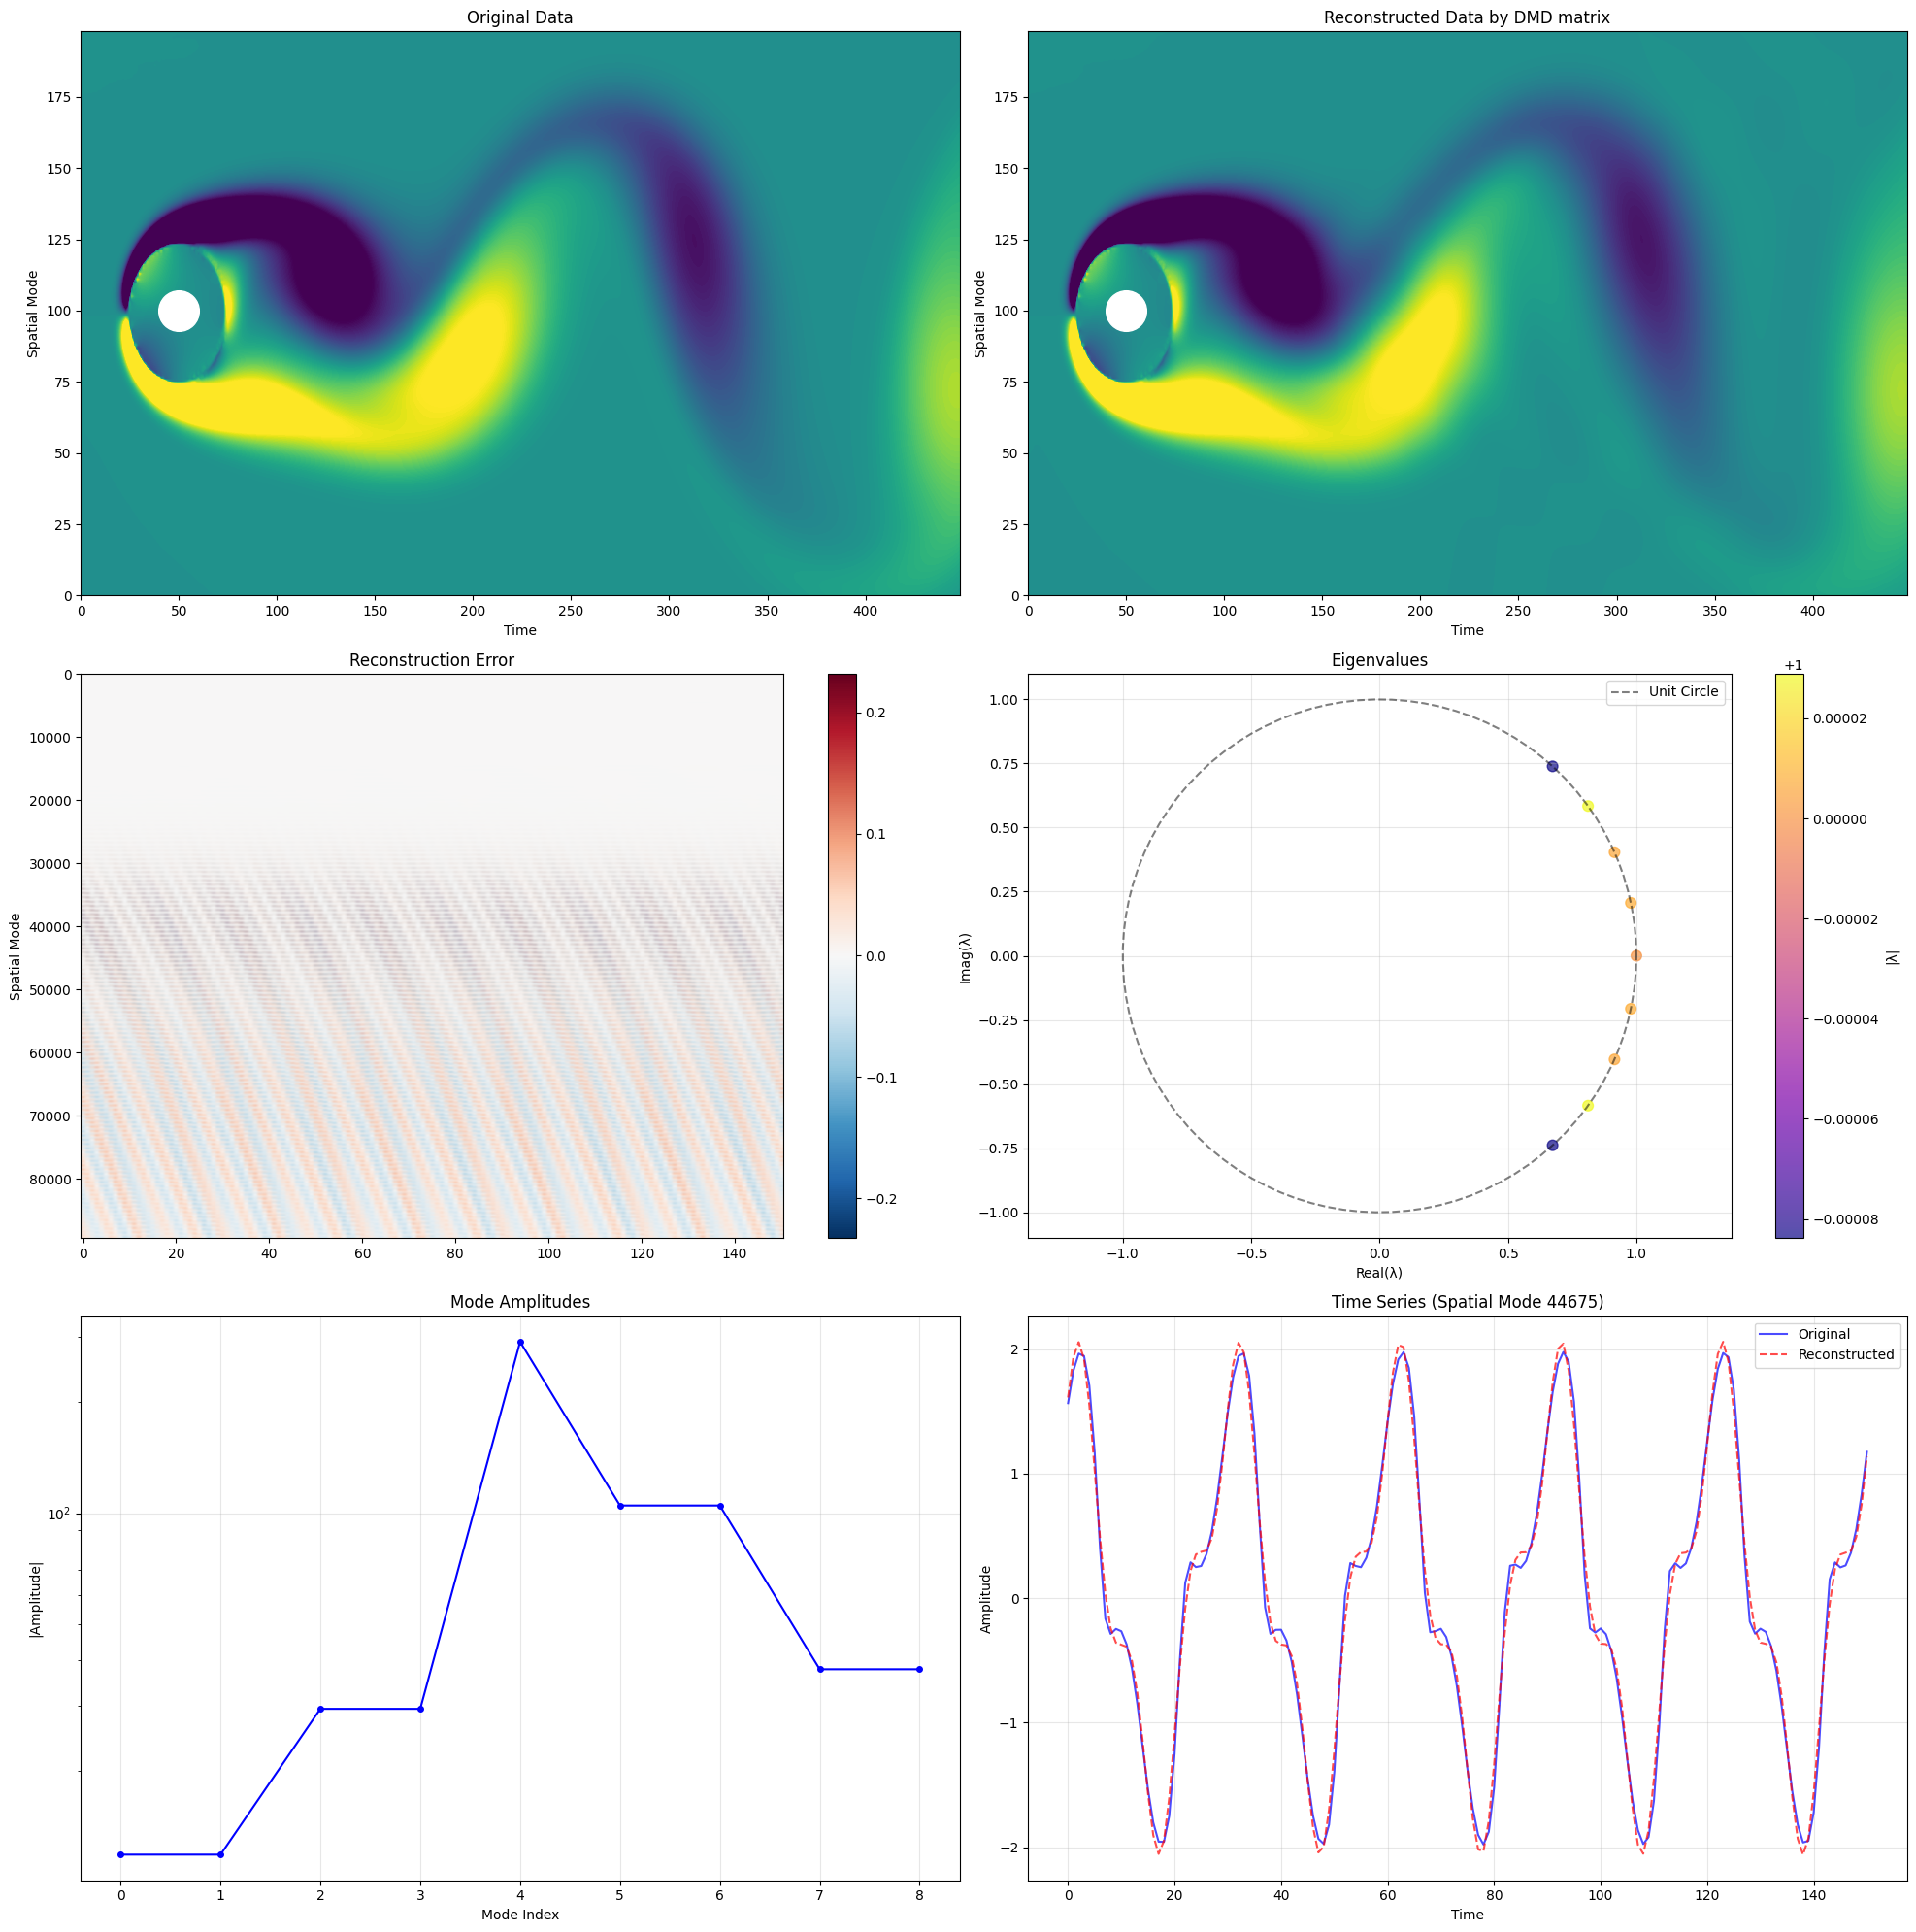

Starting benchmark analysis...
Testing SVD rank: 1
Starting HODMD-TT Analysis
Input data shape: (449, 199, 151)
Algorithm 1: TT Decomposition
TT decomposition successful with ranks: [(1, 449, 20), (20, 199, 20), (20, 151, 1)]
Algorithm 2: Orthogonalization
Orthogonalization completed
Algorithm 3: Pseudo Inverse Computation
Pseudo inverse computed with effective rank: 20
Algorithm 4: DMD Computation
DMD computation completed with 9 modes
Eigenvalue magnitudes range: [0.999916, 1.000029]
Creating Hankel matrix with shape=(89351, 151)...
Algorithm 5: Data Reconstruction
Reconstruction completed with relative error: 0.031082
Algorithm 6: Quality Assessment
Quality Statistics:
  Relative Error: 0.031082
  Energy Ratio: 0.999214
  Correlation: 0.999517
  Stable/Unstable Modes: 2/7
Testing SVD rank: 2
Starting HODMD-TT Analysis
Input data shape: (449, 199, 151)
Algorithm 1: TT Decomposition
TT decomposition successful with ranks: [(1, 449, 20), (20, 199, 20), (20, 151, 1)]
Algorithm 2: Orthog

In [ ]:

# Example usage and test
def create_test_data():
    """Create synthetic spatiotemporal data for testing"""
    print("Creating synthetic test data...")
    
    # # Spatial grid
    # x = np.linspace(0, 4*np.pi, 20)
    # y = np.linspace(0, 4*np.pi, 20)
    # X, Y = np.meshgrid(x, y)
    
    # # Time vector
    # t = np.linspace(0, 10, 1000)
    
    # # Create tensor data with multiple modes
    # f = np.zeros((20, 20, 1000))
    
    # # Mode 1: Traveling wave
    # for i, time in enumerate(t):
    #     f[:, :, i] += np.sin(X - 0.5*time) * np.cos(Y)
    
    # # Mode 2: Decaying oscillation
    # for i, time in enumerate(t):
    #     f[:, :, i] += 0.5 * np.exp(-0.1*time) * np.cos(2*X + time) * np.sin(Y)
    
    # # Mode 3: Growing instability (small amplitude)
    # for i, time in enumerate(t):
    #     f[:, :, i] += 0.1 * np.exp(0.05*time) * np.sin(X + Y + 2*time)
    from scipy import io
    data = io.loadmat('../dataset/VORTALL.mat')
    X = data['VORTALL']
    X = X[:,:]
    # Add some noise
    print(X.shape)
    f = X.reshape(449,199,-1)
    
    print(f"Test data created with shape: {f.shape}")
    return f
# Run example

if __name__ == "__main__":



    test_data = create_test_data()
    
    # Initialize HODMD-TT
    hodmd = HODMD_TT(rank=20, svd_rank=20)
    
    # Fit the model
    reconstructed_data, quality_stats = hodmd.fit(test_data)
    
    # Visualize results
    hodmd.visualize_results(test_data, reconstructed_data)
    hodmd.benchmark_analysis(test_data,reconstructed_data)
    print("\nHODMD-TT Analysis Complete!")
    print("=" * 50)